# Анализ профессиональных матчей Dota 2

**Данные**

[Источник данных](https://www.kaggle.com/datasets/bwandowando/dota-2-pro-league-matches-2023/data)

Данные актуальные, выкачиваются с kaggle, разархивируются и объединяются в целые таблицы. Далее оставляются только потенциально интересные для исследования признаки, из них формируется локальная база данных SQLite. Дальнейшая работа производится с ней.

Итоговые данные состоят из 9 таблиц  

Основные:
- `matches` - информация о матчах
- `players` - информация об игроках и их активностях
- `teams` - информация о командах
- `picks_bans` - информация о стадии пиков/банов героев в каждом матче

Вспомогательные:
- `heroes` - инфо о героях
- `items` - инфо о предметах
- `leagues` - инфо о профессиональных лигах
- `patch` - инфо о патчах (версиях) игры
- `regions` - инфо о регионе сервера матча

**Цель исследования**

Посмотреть, что происходит на профессиональной сцене Dota 2 в последнем патче: посмотреть на героев, предметы, их винрейт, на длительность матча и время первого фб. И посмотреть на некоторые командные показатели, и определить, влияют ли они на победу в матче, или нет.

In [1]:
# %%capture
# !pip install -U kaleido

In [2]:
import os
import shutil
import warnings
import pandas as pd
import numpy as np

import sqlite3

from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind

import matplotlib.pyplot as plt
from seaborn import heatmap
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

In [3]:
#отображение больших чисел полностью
pd.set_option('display.float_format', '{:.2f}'.format)

#отключение текста предупреждений pandas
pd.options.mode.chained_assignment = None

#отключение текста предупреждений DtypeWarning
warnings.filterwarnings("ignore", category=pd.errors.DtypeWarning)

#параметры отображения графиков
# pio.renderers.default='notebook'
# pio.renderers.default='colab'

#рендеринг графиков как SVG (менее ресурсозатратный формат)
pio.renderers.default = 'svg'

# Подключение к бд

In [4]:
!gdown 'https://drive.google.com/uc?id=1xGib5pimKV7XipnwLNNTL8aXGzh5RLjj'

Downloading...
From (original): https://drive.google.com/uc?id=1xGib5pimKV7XipnwLNNTL8aXGzh5RLjj
From (redirected): https://drive.google.com/uc?id=1xGib5pimKV7XipnwLNNTL8aXGzh5RLjj&confirm=t&uuid=7d16b03c-55b6-4860-a1e8-c582db594acc
To: /content/dota_pro_matches.db
100% 265M/265M [00:02<00:00, 126MB/s]


In [5]:
conn = sqlite3.connect('/content/dota_pro_matches.db')
c = conn.cursor()

In [6]:
pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)

name
0     players
1     matches
2  picks_bans
3       teams
4      heroes
5     leagues
6       patch
7     regions
8       items

В базе 9 таблиц: герои, предметы, лиги, патчи, регионы, матчи, информация о пиках-банах, игроки, команды.

## Основные таблицы

In [7]:
# @title matches
pd.read_sql("PRAGMA table_info(matches);", conn)

cid              name     type  notnull dflt_value  pk
0    0          match_id  INTEGER        0       None   0
1    1          duration  INTEGER        0       None   0
2    2  first_blood_time  INTEGER        0       None   0
3    3          leagueid  INTEGER        0       None   0
4    4       radiant_win  INTEGER        0       None   0
5    5   start_date_time     TEXT        0       None   0
6    6            region     REAL        0       None   0

In [8]:
pd.read_sql("SELECT * FROM matches ORDER BY RANDOM() LIMIT 1;", conn)

match_id  duration  first_blood_time  leagueid  radiant_win  \
0  7735439127      1677               323     16312            0   

       start_date_time  region  
0  2024-05-13 08:31:13    3.00

Информация о матчах: id, длительность, время фб, лига, сторона-победитель, дата, регион.

In [9]:
pd.read_sql("SELECT COUNT(*) as rows, COUNT(DISTINCT match_id) as matches, MIN(start_date_time) as min_date, MAX(start_date_time) as max_date FROM matches;", conn)

rows  matches             min_date             max_date
0  158479   158479  2016-01-02 15:12:19  2024-09-30 23:52:44

Всего 158 тысяч профессиональных матчей c начала 2016 года по настоящее время. Каждая строка - один уникальный матч

In [10]:
# @title players
pd.read_sql("PRAGMA table_info(players);", conn)

cid                name     type  notnull dflt_value  pk
0     0            match_id  INTEGER        0       None   0
1     1          account_id     REAL        0       None   0
2     2             assists     REAL        0       None   0
3     3          backpack_0     REAL        0       None   0
4     4          backpack_1     REAL        0       None   0
5     5          backpack_2     REAL        0       None   0
6     6              deaths     REAL        0       None   0
7     7              denies     REAL        0       None   0
8     8  firstblood_claimed     REAL        0       None   0
9     9        gold_per_min     REAL        0       None   0
10   10          gold_spent     REAL        0       None   0
11   11         hero_damage     REAL        0       None   0
12   12        hero_healing     REAL        0       None   0
13   13             hero_id     REAL        0       None   0
14   14              item_0     REAL        0       None   0
15   15              item_1     REAL        0       None   0
16   16              item_2     REAL        0       None   0
17   17              item_3     REAL        0       None   0
18   18              item_4     REAL        0       None   0
19   19              item_5     REAL        0       None   0
20   20        item_neutral     REAL        0       None   0
21   21               kills     REAL        0       None   0
22   22           last_hits     REAL        0       None   0
23   23               level     REAL        0       None   0
24   24               pings     REAL        0       None   0
25   25        rune_pickups     REAL        0       None   0
26   26        tower_damage     REAL        0       None   0
27   27       towers_killed     REAL        0       None   0
28   28          xp_per_min     REAL        0       None   0
29   29         personaname     TEXT        0       None   0
30   30         radiant_win  INTEGER        0       None   0
31   31           isRadiant  INTEGER        0       None   0
32   32                 win     REAL        0       None   0
33   33       neutral_kills     REAL        0       None   0
34   34          lane_kills     REAL        0       None   0
35   35      observer_kills     REAL        0       None   0
36   36        sentry_kills     REAL        0       None   0
37   37        roshan_kills     REAL        0       None   0
38   38       buyback_count     REAL        0       None   0
39   39       observer_uses     REAL        0       None   0
40   40         sentry_uses     REAL        0       None   0
41   41          is_roaming  INTEGER        0       None   0
42   42     actions_per_min     REAL        0       None   0
43   43        purchase_gem     REAL        0       None   0
44   44     purchase_rapier     REAL        0       None   0

In [11]:
pd.read_sql("SELECT * FROM players ORDER BY RANDOM() LIMIT 1;", conn)

match_id   account_id  assists  backpack_0  backpack_1  backpack_2  \
0  6455338617 928499811.00     9.00      218.00        0.00        0.00   

   deaths  denies  firstblood_claimed  gold_per_min  ...  observer_kills  \
0    3.00    3.00                0.00        446.00  ...            0.00   

   sentry_kills  roshan_kills  buyback_count  observer_uses  sentry_uses  \
0          1.00          0.00           0.00           0.00         1.00   

   is_roaming  actions_per_min  purchase_gem  purchase_rapier  
0           0             0.00          None             None  

[1 rows x 45 columns]

Информация о действиях и событиях каждого игрока в матче, много разных показателей.

In [12]:
pd.read_sql("SELECT COUNT(DISTINCT account_id) as players FROM players;", conn)

players
0    60208

Всего 60 тысяч уникальных игроков.

In [13]:
# c.execute("SELECT COUNT(DISTINCT match_id) as matches FROM players;").fetchall()[0][0]

In [14]:
pd.read_sql("SELECT COUNT(DISTINCT match_id) as matches FROM players;", conn)

matches
0   154588

154 тысячи уникальных матчей, значит не все id матчей есть в таблице `players`. Посмотрю на эти матчи

In [15]:
# match_ids_tuple = tuple(pd.read_sql_query("SELECT DISTINCT match_id FROM players;", conn)['match_id'])
# query = f"SELECT * FROM matches WHERE match_id NOT IN ({','.join('?' for _ in match_ids_tuple)})"
# pd.read_sql_query(query, conn, params=match_ids_tuple)

In [16]:
pd.read_sql_query("SELECT * FROM matches WHERE match_id NOT IN (SELECT DISTINCT match_id FROM players)", conn)

match_id  duration  first_blood_time  leagueid  radiant_win  \
0     5939912593      1518                49     12903            0   
1     5939925225      1794                50     12903            1   
2     5940024896      1417                96     12903            1   
3     5940069746      2033               203     12903            0   
4     5940146563      1646               248     12903            0   
...          ...       ...               ...       ...          ...   
3886  6946831126      2221               229     14659            1   
3887  6946866675      1801               132     14659            1   
3888  6946901254      1808               198     14659            1   
3889  6946963144      1339               168     14659            1   
3890  6946999141      1488               192     14659            0   

          start_date_time  region  
0     2021-04-11 12:14:48    8.00  
1     2021-04-11 12:20:34    8.00  
2     2021-04-11 13:05:57    8.00  
3     2021-04-11 13:26:08    8.00  
4     2021-04-11 14:00:02    8.00  
...                   ...     ...  
3886  2023-01-01 03:50:26    3.00  
3887  2023-01-01 04:41:21    3.00  
3888  2023-01-01 05:26:30    3.00  
3889  2023-01-01 06:34:46    3.00  
3890  2023-01-01 07:10:49    3.00  

[3891 rows x 7 columns]

Почти 4к матчей. Проверил некоторые матчи по id на [dotabuff](https://dotabuff.com/), они есть, сыграны. Если в `matches` есть матчи без игроков в `players`, то далее буду использовать только матчи в полном составе, со всеми 10 игроками.

In [17]:
len(set(pd.read_sql("SELECT match_id FROM players GROUP BY match_id HAVING COUNT(account_id) = 10;", conn)['match_id']))

154477

Таких матчей большинство

In [18]:
# @title teams
pd.read_sql("PRAGMA table_info(teams);", conn)

cid             name     type  notnull dflt_value  pk
0    0         match_id  INTEGER        0       None   0
1    1         leagueid  INTEGER        0       None   0
2    2  radiant.team_id  INTEGER        0       None   0
3    3     radiant.name     TEXT        0       None   0
4    4      radiant.tag     TEXT        0       None   0
5    5     dire.team_id  INTEGER        0       None   0
6    6        dire.name     TEXT        0       None   0
7    7         dire.tag     TEXT        0       None   0

In [19]:
pd.read_sql("SELECT * FROM teams ORDER BY RANDOM() LIMIT 1;", conn)

match_id  leagueid  radiant.team_id   radiant.name radiant.tag  \
0  4506449615     10375          6461002  Bandits River          BR   

   dire.team_id         dire.name    dire.tag  
0       4482446  InquisitorGaming  Inquisitor

Информация о командах в каждом матче: id, имя и таг команд, а так же id матча и лига.

In [20]:
pd.read_sql("SELECT COUNT(DISTINCT match_id) as matches FROM teams;", conn)

matches
0   154588

В `teams` 154к матчей, в `matches` их больше.

In [21]:
# @title picks_bans
pd.read_sql("PRAGMA table_info(picks_bans);", conn)

cid      name     type  notnull dflt_value  pk
0    0   is_pick  INTEGER        0       None   0
1    1   hero_id     REAL        0       None   0
2    2      team     REAL        0       None   0
3    3     order     REAL        0       None   0
4    4  match_id  INTEGER        0       None   0
5    5  leagueid  INTEGER        0       None   0

In [22]:
pd.read_sql("SELECT * FROM picks_bans ORDER BY RANDOM() LIMIT 1;", conn)

is_pick  hero_id  team  order    match_id  leagueid
0        0    23.00  1.00  19.00  5835494376     12214

Информация о пиках и банах каждого матча: id героя, идентификатор пикнули/забанили, очередь, сторона, id матча и лиги

In [23]:
pd.read_sql("SELECT COUNT(DISTINCT match_id) FROM picks_bans;", conn)

COUNT(DISTINCT match_id)
0                    153130

153к матчей в пиках-банах. Не все матчи сыграны в соревновательном режиме?

In [24]:
pd.read_sql("SELECT DISTINCT match_id FROM matches WHERE match_id NOT IN (SELECT DISTINCT match_id FROM picks_bans);", conn).sample(10)

match_id
3046  6887318513
305   3231593082
2155  6812897785
482   4319197226
2453  6837430682
1977  6798054460
5269  7737833671
2268  6821091979
4473  6934345031
1664  6758211535

Нет, при проверке случайных матчей на [dotabuff](https://dotabuff.com/) оказалось, что почти все сыграны в классическом соревновательном режиме с пиками-банами.

Тогда буду использовать те матчи, которые есть в `picks_bans`, ибо это важная информация.

## Вспомогательные таблицы

In [25]:
# @title heroes
pd.read_sql("PRAGMA table_info(heroes);", conn)

cid               name     type  notnull dflt_value  pk
0     0                 id  INTEGER        0       None   0
1     1               name     TEXT        0       None   0
2     2       primary_attr     TEXT        0       None   0
3     3        attack_type     TEXT        0       None   0
4     4              roles     TEXT        0       None   0
5     5                img     TEXT        0       None   0
6     6               icon     TEXT        0       None   0
7     7        base_health  INTEGER        0       None   0
8     8  base_health_regen     REAL        0       None   0
9     9          base_mana  INTEGER        0       None   0
10   10    base_mana_regen     REAL        0       None   0
11   11         base_armor  INTEGER        0       None   0
12   12            base_mr  INTEGER        0       None   0
13   13    base_attack_min  INTEGER        0       None   0
14   14    base_attack_max  INTEGER        0       None   0
15   15           base_str  INTEGER        0       None   0
16   16           base_agi  INTEGER        0       None   0
17   17           base_int  INTEGER        0       None   0
18   18           str_gain     REAL        0       None   0
19   19           agi_gain     REAL        0       None   0
20   20           int_gain     REAL        0       None   0
21   21       attack_range  INTEGER        0       None   0
22   22   projectile_speed  INTEGER        0       None   0
23   23        attack_rate     REAL        0       None   0
24   24   base_attack_time  INTEGER        0       None   0
25   25       attack_point     REAL        0       None   0
26   26         move_speed  INTEGER        0       None   0
27   27          turn_rate     REAL        0       None   0
28   28         cm_enabled  INTEGER        0       None   0
29   29               legs  INTEGER        0       None   0
30   30         day_vision  INTEGER        0       None   0
31   31       night_vision  INTEGER        0       None   0
32   32     localized_name     TEXT        0       None   0

In [26]:
pd.read_sql("SELECT * FROM heroes ORDER BY RANDOM() LIMIT 1;", conn)

id                               name primary_attr attack_type  \
0  90  npc_dota_hero_keeper_of_the_light          int      Ranged   

                              roles  \
0  ['Support', 'Nuker', 'Disabler']   

                                                 img  \
0  /apps/dota2/images/dota_react/heroes/keeper_of...   

                                                icon  base_health  \
0  /apps/dota2/images/dota_react/heroes/icons/kee...          120   

   base_health_regen  base_mana  ...  attack_rate  base_attack_time  \
0               0.25         75  ...         1.70               100   

   attack_point  move_speed  turn_rate  cm_enabled  legs  day_vision  \
0          0.30         320       0.70           1     2        1800   

   night_vision       localized_name  
0           800  Keeper of the Light  

[1 rows x 33 columns]

In [27]:
pd.read_sql("SELECT COUNT(*) as heroes FROM heroes;", conn)

heroes
0     125

В `heroes` 125 уникальных героев с описанием множества характеристик.

In [28]:
# @title items
pd.read_sql("PRAGMA table_info(items);", conn)

cid        name     type  notnull dflt_value  pk
0     0        item     TEXT        0       None   0
1     1          id  INTEGER        0       None   0
2     2       dname     TEXT        0       None   0
3     3        qual     TEXT        0       None   0
4     4        cost     REAL        0       None   0
5     5       notes     TEXT        0       None   0
6     6          mc  INTEGER        0       None   0
7     7          cd  INTEGER        0       None   0
8     8        lore     TEXT        0       None   0
9     9  components     TEXT        0       None   0
10   10     created  INTEGER        0       None   0
11   11     charges     REAL        0       None   0

In [29]:
pd.read_sql("SELECT * FROM items ORDER BY RANDOM() LIMIT 1;", conn)

item  id                 dname  qual   cost notes  mc  cd lore  \
0  recipe_cyclone  99  Eul's Scepter Recipe  None 675.00         0   0        

  components  created  charges  
0       None        0     0.00

In [30]:
pd.read_sql("SELECT COUNT(*) as items FROM items;", conn)

items
0    459

Всего 459 предметов с их описанием и характеристиками.

In [31]:
# @title leagues
pd.read_sql("PRAGMA table_info(leagues);", conn)

cid        name     type  notnull dflt_value  pk
0    0    leagueid  INTEGER        0       None   0
1    1  leaguename     TEXT        0       None   0
2    2        tier     TEXT        0       None   0

In [32]:
pd.read_sql("SELECT * FROM leagues ORDER BY RANDOM() LIMIT 1;", conn)

leagueid               leaguename          tier
0      4618  Dota 2 Challenge Mexico  professional

In [33]:
pd.read_sql("SELECT COUNT(*) as leagues FROM leagues;", conn)

leagues
0     7578

id лиги, название и её тир. 7578 разных лиг. Интересно, не думал что в профессиональной доте их настолько много.

In [34]:
# @title patch
pd.read_sql("PRAGMA table_info(patch);", conn)

cid   name  type  notnull dflt_value  pk
0    0  patch  REAL        0       None   0
1    1   date  TEXT        0       None   0

In [35]:
pd.read_sql("SELECT * FROM patch ORDER BY RANDOM() LIMIT 1;", conn)

patch                      date
0   7.18  2018-06-24T00:00:00.000Z

In [36]:
pd.read_sql("SELECT COUNT(*) as patches, MIN(date) as min_date, MAX(date) as max_date FROM patch;", conn)

patches              min_date                  max_date
0       57  2010-12-24T00:00:00Z  2024-08-01T07:30:27.355Z

Патч и его дата релиза. Всего 57 патчей с конца 2010 года.

Похоже здесь вообще все патчи второй доты, из беты игра вышла только в 2013 году, а первый The International был в августе 2011.

In [37]:
# @title regions
pd.read_sql("PRAGMA table_info(regions);", conn)

cid      name     type  notnull dflt_value  pk
0    0  regionid  INTEGER        0       None   0
1    1         0     TEXT        0       None   0

In [38]:
pd.read_sql("SELECT * FROM regions ORDER BY RANDOM() LIMIT 1;", conn)

regionid      0
0        19  JAPAN

In [39]:
pd.read_sql("SELECT COUNT(*) as regions FROM regions;", conn)

regions
0       22

id региона, и его название. Всего 22 строки.

# Агрегирование и выгрузка данных

Dota 2 - одна из самых популярных компьютерных игр в мире. Одна из её особенностей - изменчивость на протяжении времени. Игре уже больше 10 лет, и все это время её развитие не стоит на месте, за это время очень многое поменялось. Одних героев, со времени выхода игры из бета-теста в июле 2013 года добавилось аж [24](https://liquipedia.net/dota2/Heroes_by_release) штуки. Прочих разных особенностей, игровых механик, предметов, изменений карты и того больше. А точечные фиксы характеристик и скилов героев и предметов выходят чуть ли не каждый месяц.

Поэтому доту имеет смысл описывать отрезками, в пределах одного крупного патча. Поскольку данные у нас свежие, я буду описывать текущую мету - матчи, сыгранные с последнего крупного патча [7.33](https://liquipedia.net/dota2/Version_7.33) и до настоящего времени.

In [40]:
#создаю временную таблицу с айдишниками матчей, с которыми буду работать
c.execute(
    """
    CREATE TEMP TABLE ids as
    SELECT match_id
    FROM (
        SELECT match_id, account_id
        FROM players
    ) p
    JOIN (SELECT DISTINCT match_id FROM picks_bans) pb USING (match_id)
    JOIN (SELECT match_id FROM teams) t USING (match_id)
    JOIN (SELECT match_id, start_date_time FROM matches) m USING (match_id)
    WHERE start_date_time > (SELECT DATETIME(date) FROM patch WHERE patch = 7.33)
    GROUP BY match_id
    HAVING COUNT(account_id) = 10;
    """
)

In [41]:
pd.read_sql("SELECT COUNT(*) AS matches, DATE(MIN(start_date_time)) AS date FROM matches JOIN ids USING(match_id);", conn)

matches        date
0    42199  2023-04-21

Больше 42к матчей с апреля прошлого года. Неплохо.


Посмотрю на размер датасетов, с которыми предстоит работать

In [42]:
#размер самого большого датасета players
str(round(
    pd.read_sql("SELECT * FROM players JOIN ids USING(match_id) LIMIT 1;", conn).memory_usage(index=False).sum() *
    pd.read_sql("SELECT COUNT(*) AS cnt FROM players JOIN ids USING(match_id);", conn).iloc[0,0] / 1_000_000, 1)) + ' mb'

'151.9 mb'

Самый большой датасет `players` с информацией о матчах за исследуемый период будет занимать 144 мб в оперативной памяти. Остальные - в разы меньше.  
В данном случае могу себе позволить выгрузить их из базы и работать с ними в pandas, чтобы постоянно не обращаться запросами к базе.

In [43]:
players = pd.read_sql("SELECT * FROM players JOIN ids USING(match_id);", conn)
players.memory_usage(index=True).sum() / 1_000_000

151.916528

Действительно, `players` весит 152 мб. Выгружу остальные данные.

In [44]:
#основные данные
matches, teams, picks_bans =  (
    pd.read_sql("SELECT * FROM matches JOIN ids USING(match_id);", conn),
    pd.read_sql("SELECT * FROM teams JOIN ids USING(match_id);", conn),
    pd.read_sql("SELECT * FROM picks_bans JOIN ids USING(match_id);", conn)
)

In [45]:
#вспомогательные таблицы, тут выгружаю не все поля для удобства
heroes, items, leagues, regions = (
    pd.read_sql("SELECT id, name, localized_name FROM heroes;", conn),
    pd.read_sql("SELECT id, dname, qual, cost FROM items;", conn),
    pd.read_sql("SELECT * FROM leagues;", conn),
    pd.read_sql("SELECT * FROM regions;", conn),
)

In [46]:
#все таблицы выгрузили, закрываем соединение с базой
conn.close()

# Анализ


Так как дота, а тем более её профессиональная сцена, игра командная - в этом исследовании я буду смотреть исключительно на командные показатели.

## Общая информация о матчах

In [47]:
#color_discrete_map={'Radiant': "#636EFA", 'Dire': "#EF553B"} #blue red
#color_discrete_map={'Radiant': "#598307", 'Dire': "#A83806"} #base colors: https://liquipedia.net/dota2/Template:Color
#color_discrete_map={'Radiant': "#2CA02C", 'Dire': "#D62728"} #greed redwine

color_discrete_map={
    'Radiant': "MediumSpringGreen", 'Dire': "IndianRed", #greed redwine
    'Победитель':'#636EFA', 'Проигравший':'#EF553B'      #blue red
    }

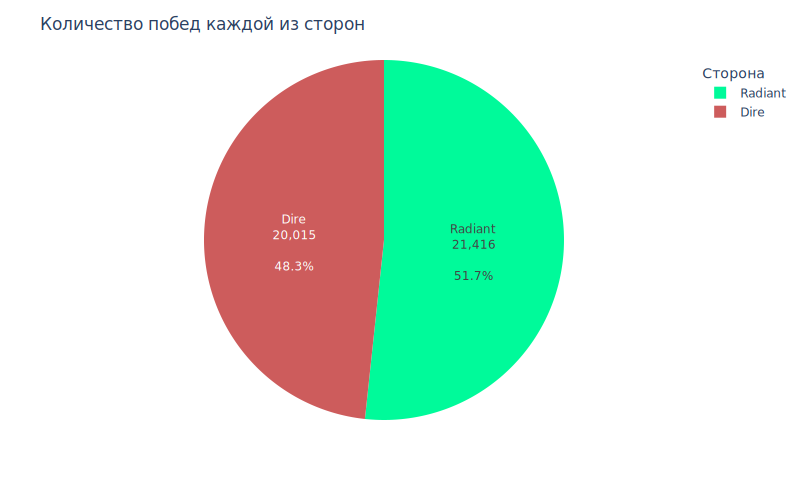

In [48]:
# @title Количество побед каждой из сторон

pv = matches.groupby('radiant_win', as_index=False)['match_id'].count()
pv['radiant_win_sides'] = pv.radiant_win.map(lambda x: 'Radiant' if x == 1 else 'Dire')

fig = px.pie(
    pv,
    names='radiant_win_sides',
    values='match_id',
    color='radiant_win_sides',
    color_discrete_map=color_discrete_map
)
fig.update_layout(title='Количество побед каждой из сторон',
                  legend_title='Сторона',
                  height=500,
                  width=800)
fig.update_traces(textinfo='label+value+percent',
                  hovertemplate='Победитель: %{label}<br>Количество: %{value}<br>Процент: %{percent}')
fig.show()

За все почти полтора года Radiant выиграли на 1400 матчей больше, чем Dire.

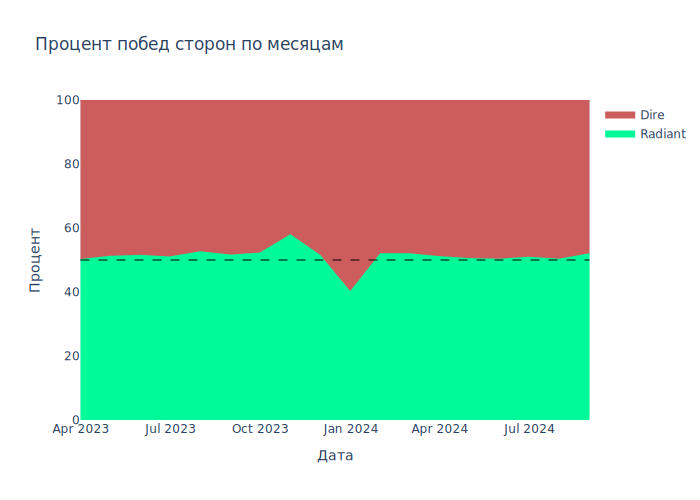

In [49]:
# @title Нормированный график винрейта по месяцам

pv = matches[['match_id', 'radiant_win', 'start_date_time']]
pv['start_date_time'] = pd.to_datetime(pv['start_date_time'])
pv['year_month'] = pv['start_date_time'].dt.strftime('%Y-%m')
pv = pv.groupby('year_month', as_index=False).agg(matches=('match_id','count'), radiant_win=('radiant_win','sum'))
pv['radiant_winrate'] = round(pv.radiant_win / pv.matches * 100, 1)
pv['dire_winrate'] = round((pv.matches - pv.radiant_win) / pv.matches * 100, 1)

# Построение диаграммы с областями
fig = go.Figure()

colors = list(color_discrete_map.values())

fig.add_trace(go.Scatter(
    x=pv["year_month"],
    y=pv['radiant_winrate'],
    name='Radiant',
    mode='lines',
    stackgroup='one',
    customdata=pv["matches"].values,
    hovertemplate='Дата: %{x}<br>Винрейт Radiant: %{y}%<br>Всего матчей: %{customdata}<extra></extra>',
    fill='tonexty',
    fillcolor=colors[0],
    line=dict(color=colors[0]),
    )
)

fig.add_trace(go.Scatter(
    x=pv["year_month"],
    y=pv['dire_winrate'],
    name='Dire',
    mode='lines',
    stackgroup='one',
    hoverinfo='skip',
    fill='tonexty',
    fillcolor=colors[1],
    line=dict(color=colors[1]),
    )
)

fig.add_shape(
    type='line',
    x0=pv["year_month"].min(),
    y0=50,
    x1=pv["year_month"].max(),
    y1=50,
    line=dict(
        color="Black",
        width=1,
        dash="dash"
    )
)
# Настроить внешний вид
fig.update_layout(
    title='Процент побед сторон по месяцам',
    xaxis=dict(title='Дата'),
    yaxis=dict(title='Процент', range=[0, 100])
)
# Показать диаграмму
fig.show()

Интересно, что Dire выигрывали только в январе 24 года, все остальное время Radiant выигрывают немного чаще.

In [50]:
# Правило Стерджеса - расчет количества бинов в гистограмме
def sturges(column:pd.core.series.Series) -> int:
  '''
  Функция определения количества бинов гистограммы по правилу Стерджеса
  Args:
    column (pd.core.series.Series): объект series содержащий наблюдения
  Returns:
    int: количество бинов гистограммы
  '''
  from math import log2
  return int(round(log2(len(column))+1))

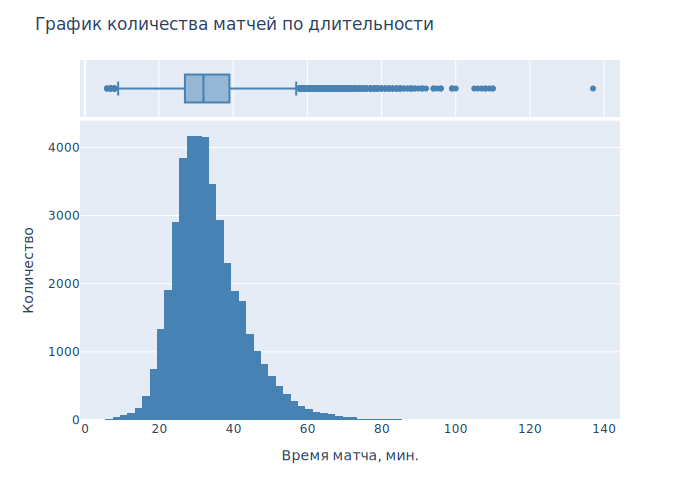

In [51]:
# @title График количества матчей по длительности

pv = matches[['match_id', 'duration']]
pv['duration_minutes'] = round(pv['duration'] / 60)

fig = px.histogram(
    pv,
    x="duration_minutes",
    y="match_id",
    #color="radiant_win",
    histfunc="count",
    #nbins=sturges(pv.match_id),
    nbins=pv.duration_minutes.nunique(),
    marginal="box", #box, violin, rug
    color_discrete_sequence=['SteelBlue']
)
fig.update_layout(
    title='График количества матчей по длительности',
    xaxis_title='Время матча, мин.',
    yaxis_title='Количество'
)
fig.update_traces(hovertemplate='Матчей: %{y}<br>Продолжительность: %{x} мин.')
fig.show()

Медианное время матча - 32 минуты. Матчи больше 57 минут уже считаются выбросами.

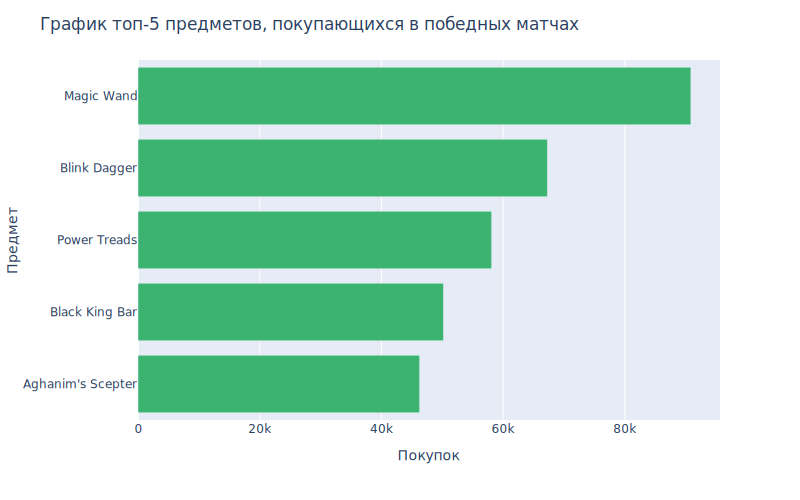

In [52]:
# @title Предметы - топ-5 победных

items_columns = players.query('win == 1')[['item_0', 'item_1', 'item_2', 'item_3', 'item_4', 'item_5']]
all_items = items_columns.values.flatten()
value_counts_win = pd.Series(all_items).value_counts()
top_5_items_win = value_counts_win[value_counts_win.index != 0].iloc[0:5]
top_5_items_win = (
    items[['id', 'dname']]
    .merge(
        top_5_items_win,
        left_on='id',
        right_index=True,
        how='inner'
    )
    .set_index('id')
)
# top_5_items_win.columns = ['Предмет', 'Матчей']

fig = px.bar(
    top_5_items_win.sort_values('count'),
    y='dname',
    x='count',
    color_discrete_sequence=['MediumSeaGreen']
)
fig.update_layout(
    title='График топ-5 предметов, покупающихся в победных матчах',
    yaxis_title='Предмет',
    xaxis_title='Покупок',
    height=500,
    width=800
)
fig.update_traces(hovertemplate='Предмет: %{label}<br>Покупок: %{value}')
fig.show()

В среднем больше двух magic wand'ов за матч покупается в каждой победившей команде.

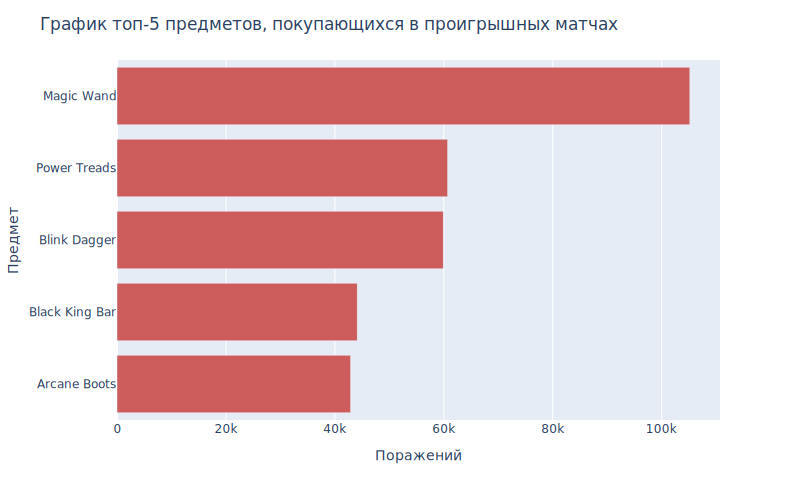

In [53]:
# @title Предметы - топ-5 проигрышных

items_columns = players.query('win == 0')[['item_0', 'item_1', 'item_2', 'item_3', 'item_4', 'item_5']]
all_items = items_columns.values.flatten()
value_counts_lose = pd.Series(all_items).value_counts()
top_5_items_lose = value_counts_lose[value_counts_lose.index != 0].iloc[0:5]
top_5_items_lose = (
    items[['id', 'dname']]
    .merge(
        top_5_items_lose,
        left_on='id',
        right_index=True,
        how='inner'
    )
    .set_index('id')
)
# top_5_items_lose.columns = ['Предмет', 'Матчей']

fig = px.bar(
    top_5_items_lose.sort_values('count'),
    y='dname',
    x='count',
    color_discrete_sequence=['IndianRed']
)
fig.update_layout(
    title='График топ-5 предметов, покупающихся в проигрышных матчах',
    yaxis_title='Предмет',
    xaxis_title='Поражений',
    height=500,
    width=800
)
fig.update_traces(hovertemplate='Предмет: %{label}<br>Поражений: %{value}')
fig.show()

Magic wand так же покупается и проигравшими командами - по два с половиной на команду за матч.

В топ-5 выигрышных и проигрышных предметов различается только один предмет - у победителей есть аганим, у проигравших - ботинки на ману.

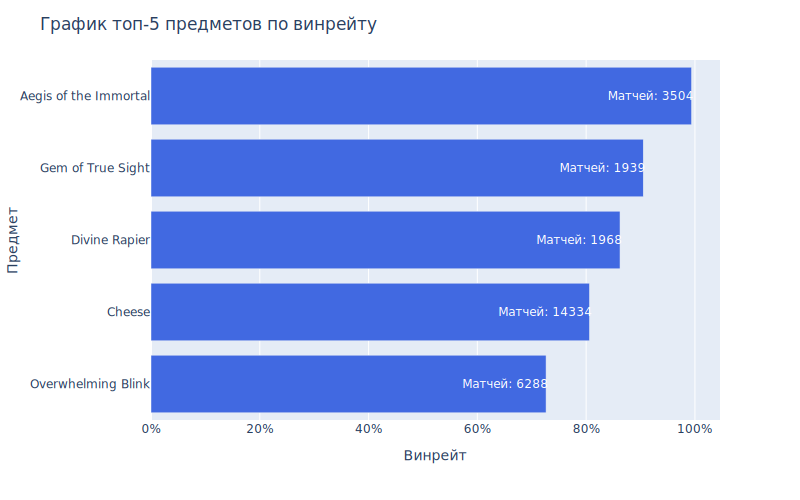

In [54]:
# @title Предметы - топ-5 по винрейту
items_columns = players[['item_0', 'item_1', 'item_2', 'item_3', 'item_4', 'item_5']]
all_items = items_columns.values.flatten()
value_counts_all = pd.Series(all_items).value_counts()

items_winrate = value_counts_all.to_frame().join(value_counts_win, lsuffix='_all', rsuffix='_win')
items_winrate['item_winrate'] = items_winrate['count_win'] / items_winrate['count_all']
#items_winrate['item_winrate'] = round(items_winrate['count_win'] / items_winrate['count_all'] * 100)

top_5_items_winrate = (
    items_winrate
    .query('count_all > 1000')
    .sort_values('item_winrate', ascending=False)
    .head(5)
    .merge(items[['id', 'dname']], left_index=True, right_on='id', how='inner')
    .set_index('id')
)
#top_5_items_winrate.columns = ['Матчей', 'Побед', 'Винрейт', 'Предмет']

fig = px.bar(
    top_5_items_winrate.sort_values('item_winrate'),
    y='dname',
    x='item_winrate',
    color_discrete_sequence=['RoyalBlue']
)
fig.update_layout(
    title='График топ-5 предметов по винрейту',
    yaxis_title='Предмет',
    xaxis_title='Винрейт',
    height=500,
    width=800,
    xaxis_tickformat = '.0%'
)
fig.update_traces(
    text=top_5_items_winrate['count_all'].apply(lambda x: f'Матчей: {x}'),
    hovertemplate='Предмет: %{label}<br>Винрейт: %{value}'
)

fig.show()

С аегисом и сыром результат ожидаемый - эти предметы дают большое преимущество, для их получения надо забрать рошана. А на про сцене почти всегда забрать рошана = выиграть драку, соответственно уже быть сильнее противника.

С рапирой и топовым блинком тоже понятно - топовые предметы, их обычно берут когда уже доминируют над соперником.

А вот у гема лично я не ожидал такого винрейта, покупают его не редко, он выпадает при смерти и может сыграть против команды, купившей его.

И да, все эти предметы относитально редко встречаются в матчах

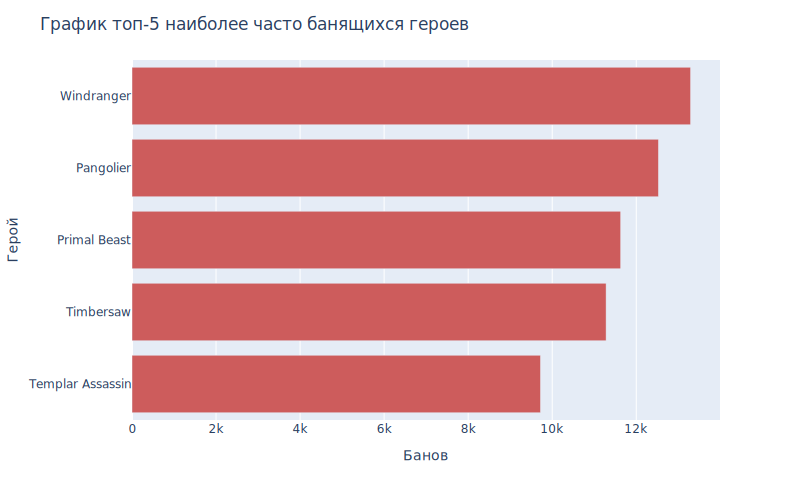

In [55]:
# @title Герои - топ-5 наиболее забаненых

top_5_heroes_bans = (
    picks_bans
    .query('is_pick == 0')
    .groupby('hero_id')['match_id']
    .count()
    .sort_values(ascending=False)
    .to_frame()
    .head(5)
    .merge(heroes[['id', 'localized_name']], left_index=True, right_on='id')
    .set_index('id')
)
#top_5_heroes_bans.columns = ['Матчей', 'Герой']

fig = px.bar(
    top_5_heroes_bans.sort_values('match_id'),
    y='localized_name',
    x='match_id',
    color_discrete_sequence=['IndianRed']
)
fig.update_layout(
    title='График топ-5 наиболее часто банящихся героев',
    yaxis_title='Герой',
    xaxis_title='Банов',
    height=500,
    width=800
)
fig.update_traces(hovertemplate='Герой: %{label}<br>Банов: %{value}')
fig.show()

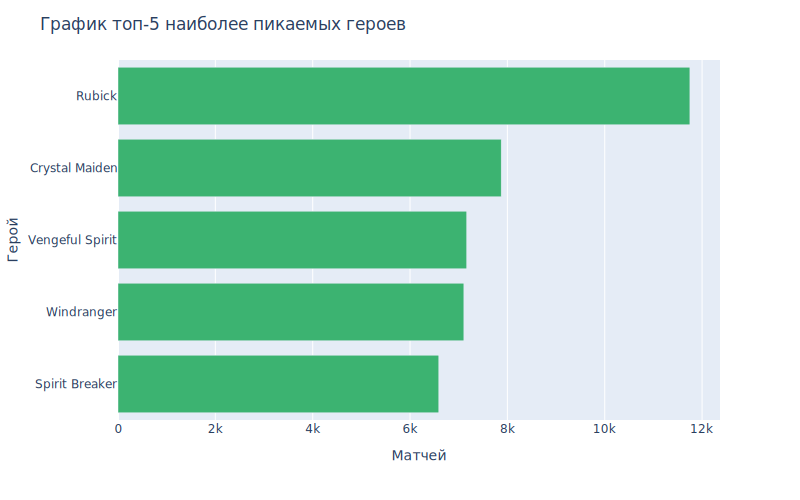

In [56]:
# @title Герои - топ-5 наиболее пикаемых

top_5_heroes_picks = (
    picks_bans
    .query('is_pick == 1')
    .groupby('hero_id')['match_id']
    .count()
    .sort_values(ascending=False)
    .to_frame()
    .head(5)
    .merge(heroes[['id', 'localized_name']], left_index=True, right_on='id')
    .set_index('id')
)
# top_5_heroes_picks.columns = ['Матчей', 'Герой']

fig = px.bar(
    top_5_heroes_picks.sort_values('match_id'),
    y='localized_name',
    x='match_id',
    color_discrete_sequence=['MediumSeaGreen']
)
fig.update_layout(
    title='График топ-5 наиболее пикаемых героев',
    yaxis_title='Герой',
    xaxis_title='Матчей',
    height=500,
    width=800
)
fig.update_traces(hovertemplate='Герой: %{label}<br>Матчей: %{value}')
fig.show()

Из топ-5 самых часто пикаемых и банившихся героев пересекается только ВР.

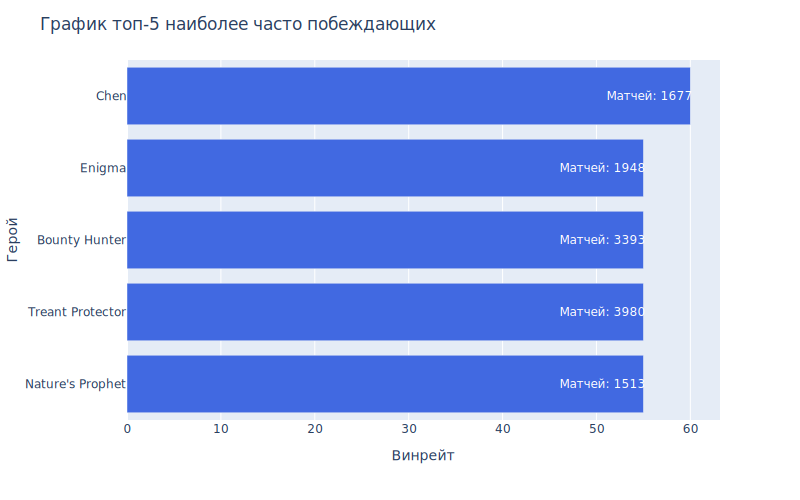

In [57]:
# @title Герои - топ-5 наиболее побеждающих

heroes_winrate = (
    players
    .groupby('hero_id')['match_id']
    .count()
    .to_frame()
    .join(
        players
        .query('win == 1')
        .groupby('hero_id')['match_id']
        .count(),
        lsuffix='_all',
        rsuffix='_win'
    )
)

heroes_winrate['winrate'] = round(
    heroes_winrate['match_id_win'] / heroes_winrate['match_id_all'] * 100
)

top_5_heroes_winrate = (
    heroes_winrate
    .sort_values('winrate', ascending=False)
    .head(5)
    .merge(heroes[['id', 'localized_name']], left_index=True, right_on='id')
    .set_index('id')
)
#top_5_heroes_winrate.columns = ['Матчей', 'Побед', 'Винрейт', 'Герой']

fig = px.bar(
    top_5_heroes_winrate.sort_values('winrate'),
    y='localized_name',
    x='winrate',
    color_discrete_sequence=['RoyalBlue']
)
fig.update_layout(
    title='График топ-5 наиболее часто побеждающих',
    yaxis_title='Герой',
    xaxis_title='Винрейт',
    height=500,
    width=800
)
fig.update_traces(
    text=top_5_heroes_winrate['match_id_all'].apply(lambda x: f'Матчей: {x}'),
    customdata = top_5_heroes_winrate['match_id_all'],
    hovertemplate='Герой: %{label}<br>Винрейт: %{value}<br>Матчей: %{customdata}'
)
fig.show()

А герои с самым высоким винрейтом не очень популярные - на трех из пяти героев не сыграно даже 2 тысяч матчей за полтора года. Видимо, в текущей мете они считаются героями ситуационными, берутся под определенную задачу или комбинацию, и в этих обстоятельствах оправдывают себя, что и отражается на высоком винрейте.

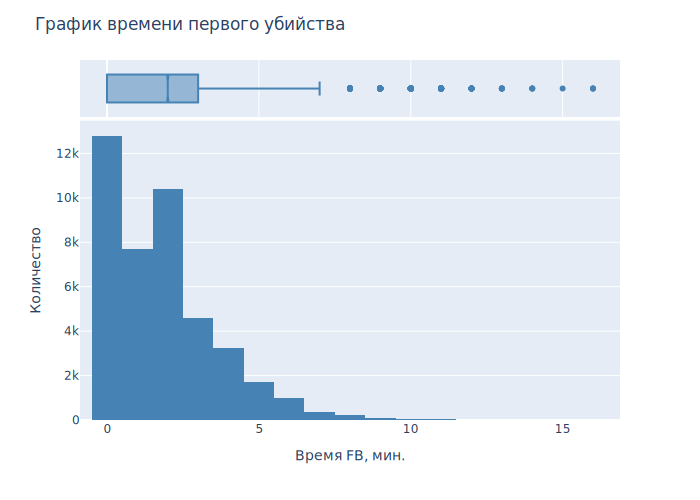

In [58]:
# @title График времени первого убийства

pv = matches[['match_id', 'first_blood_time']]
pv['first_blood_time_minutes'] = round(pv['first_blood_time'] / 60)

fig = px.histogram(
    pv,
    x="first_blood_time_minutes",
    y="match_id",
    histfunc="count",
    nbins=pv.first_blood_time_minutes.nunique(),
    marginal="box",
    color_discrete_sequence=['SteelBlue']
)
fig.update_layout(
    title='График времени первого убийства',
    xaxis_title='Время FB, мин.',
    yaxis_title='Количество'
)
fig.update_traces(hovertemplate='Матчей: %{y}<br>Время FB: %{x} мин.')
fig.show()

В большинстве матчей ФБ делают до 3 минуты, очень редко проходит больше времени. Самое позднее ФБ за время исследования - на 16 минуте

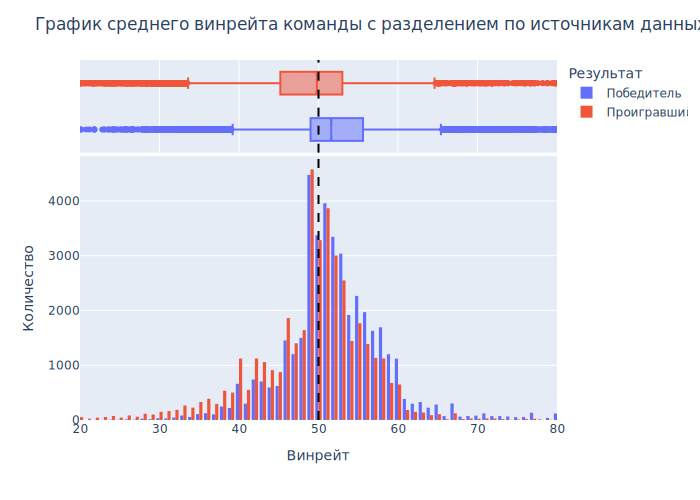

In [59]:
# @title Распределение среднего винрейта игроков команды по результатам матча

# Подсчет винрейта игроков
players_winrate = (
    players[['match_id', 'account_id']]
    .groupby('account_id')['match_id']
    .count()
    .to_frame()
    .join(
        players[['match_id', 'account_id', 'win']]
        .query('win == 1')
        .groupby('account_id')['match_id']
        .count(),
        lsuffix='_all',
        rsuffix='_win'
    )
)

players_winrate['player_winrate'] = (
    round(players_winrate.match_id_win / players_winrate.match_id_all * 100)
    .fillna(0)
)

# Подсчет среднего винрейта игроков в матчах, где они побеждали
win_players_mean_winrate = (
    players[['match_id', 'account_id', 'win']]
    .query('win == 1')
    .merge(players_winrate['player_winrate'], left_on='account_id', right_index=True)
    .groupby('match_id')
    .agg(mean_player_winrate=('player_winrate', 'mean'))
)
# Подсчет среднего винрейта игроков в матчах, где они проигрывали
lose_players_mean_winrate = (
    players[['match_id', 'account_id', 'win']]
    .query('win == 0')
    .merge(players_winrate['player_winrate'], left_on='account_id', right_index=True)
    .groupby('match_id')
    .agg(mean_player_winrate=('player_winrate', 'mean'))
)

# Добавление столбца 'result' для обозначения результатов матчей
win_players_mean_winrate['result'] = 'Победитель'
lose_players_mean_winrate['result'] = 'Проигравший'

# Объединение данных о средних винрейтах победителей и проигравших
players_mean_winrate = pd.concat([win_players_mean_winrate, lose_players_mean_winrate], ignore_index=True)

fig = px.histogram(
    players_mean_winrate,
    x="mean_player_winrate",
    y="mean_player_winrate",
    color="result",
    histfunc="count",
    nbins=round(players_mean_winrate.mean_player_winrate.nunique()/4),
    marginal="box",
    barmode='group',
    color_discrete_map=color_discrete_map
)

fig.update_layout(
    title='График среднего винрейта команды с разделением по источникам данных',
    xaxis_title='Винрейт',
    yaxis_title='Количество',
    legend=dict(title='Результат')
)
fig.update_traces(
    hovertemplate='Матчей: %{y}<br>Средний винрейт: %{x}<br>Результат: %{fullData.name}<extra></extra>',
    selector=dict(type='histogram')
)

fig.update_traces(
    hovertemplate='Средний винрейт: %{x}<br>Результат: %{y}<extra></extra>',
    selector=dict(type='box')
)
fig.add_vline(x=50, line=dict(color='Black', width=2, dash='dash'))
fig.update_xaxes(range=[20, 80])

fig.show()

Средний винрейт игроков команды имеет форму нормального распределения. При его влиянии на результат матча видно, что игроки в командах, выигрывавших матчи, имеют медианный средний винрейт 52%. И напротив, в командах которые проигрывали, игроки имеют медианный средний винрейт чуть меньше 50%.

## Общая информация о матчах по профессиональным лигам

In [60]:
pd.Series(leagues.tier.unique())

0         amateur
1         premium
2    professional
3            None
4        excluded
dtype: object

In [61]:
matches[['match_id', 'leagueid']].merge(leagues[['leagueid', 'tier']], on='leagueid').groupby('tier')['match_id'].count()

tier
premium          2037
professional    39756
Name: match_id, dtype: int64

Интересно. Почти все матчи за период исследования сыграны в профессиональной лиге. Я предполагал, что командные показатели могут отличаться в разных лигах, в зависимости от уровня игроков. Значит, эта часть исследования отменяется.

In [62]:
# The International 2023
#matches[['match_id', 'leagueid']].merge(leagues[leagues.leaguename == 'The International 2023'], on='leagueid').groupby('tier')['match_id'].count()

## Показатели, потенциально влияющие на победу в матче

На большинство показателей буду смотреть в пересчете на минуту времени матча. Одни команды заканчивают матч за 25 минут, другие играют больше часа. Поэтому привести их к виду "показатель в минуту" будет логичнее.

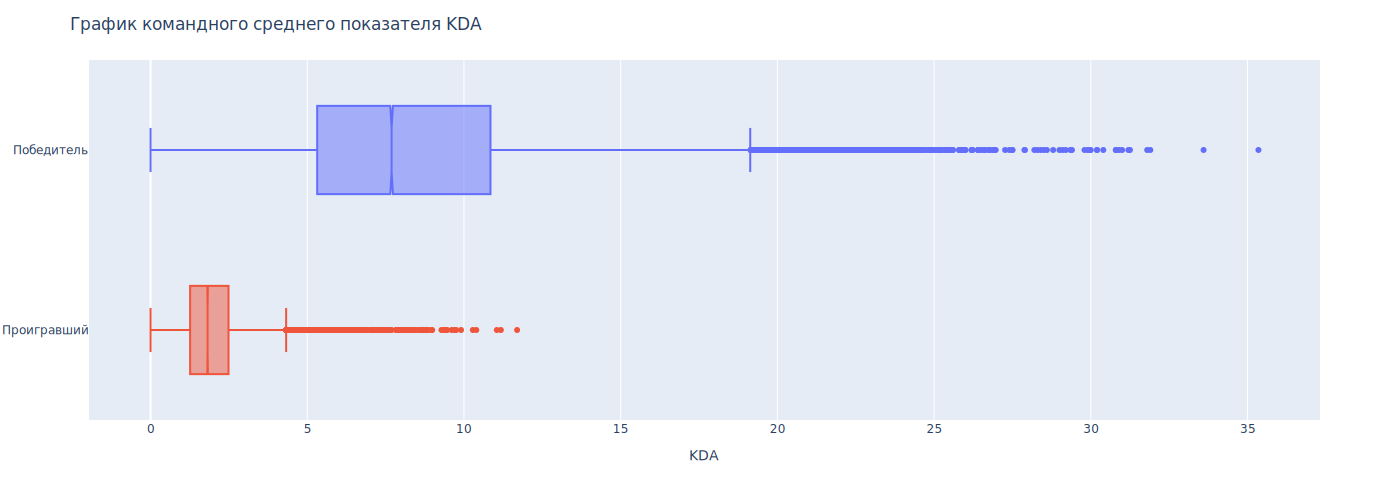

In [63]:
# @title KDA

kda = players[['match_id','account_id', 'win', 'kills', 'assists', 'deaths']]
#kda['kda'] = kda.apply(lambda row: row.kills + row.assists if row.deaths == 0 else (row.kills + row.assists) / row.deaths, axis=1)
kda['deaths'] = kda.deaths.map(lambda x: x if x != 0 else 1) #привожу показатель смертей к единице если он равен нулю во избежании деления на ноль
kda['kda'] = (kda.kills + kda.assists) / kda.deaths


winners_kda = kda.query('win == 1').groupby('match_id')['kda'].mean().to_frame()
winners_kda['result'] = 'Победитель'
losers_kda = kda.query('win == 0').groupby('match_id')['kda'].mean().to_frame()
losers_kda['result'] = 'Проигравший'
kda = pd.concat([winners_kda, losers_kda], ignore_index=True)
kda

fig = px.box(
    kda,
    x='kda',
    y='result',
    notched=True,
    color='result',
    color_discrete_map=color_discrete_map
)
fig.update_layout(
    height=500,
    width=1400,
    title='График командного среднего показателя KDA',
    xaxis_title='KDA',
    yaxis_title=None,
    #legend=dict(title='Результат')
    showlegend=False,
)

fig.show()

In [64]:
kda['is_win'] = kda.result.map(lambda x: True if x == 'Победитель' else False)
kda.kda.corr(kda.is_win)

0.7383278143487311

Показатель KDA расчитывается как (Kills + Assists) / Deaths для каждого игрока

Из графика, и по значению корреляции 0,74 понятно, что этот показатель сильно влияет на победу - чем он больше тем чаще выигрывает команда.

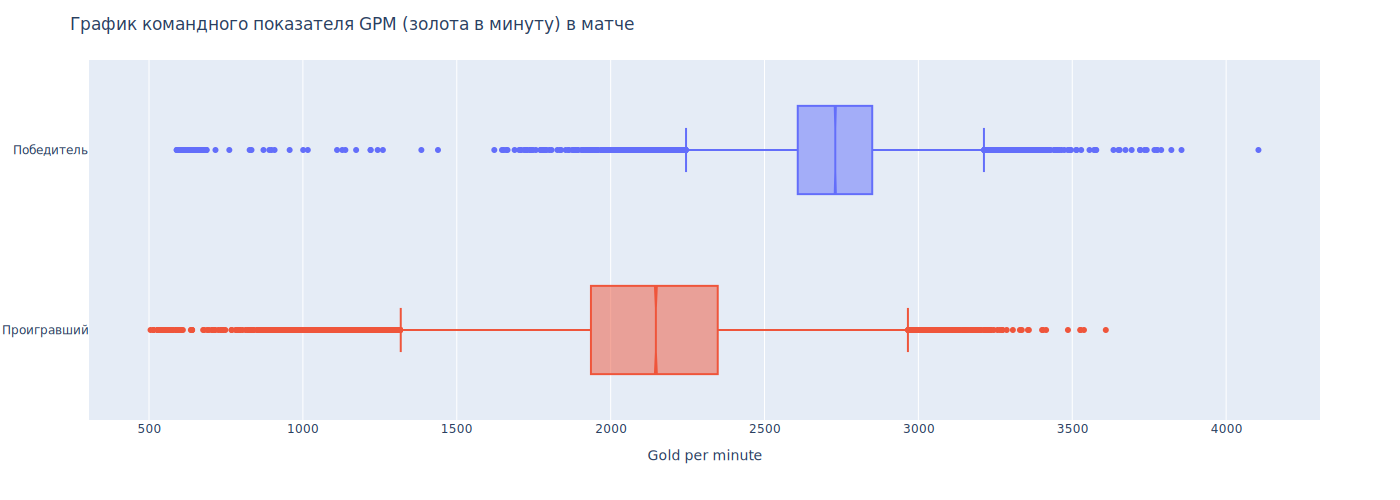

In [65]:
# @title Gold Per Minute

winners_gpm = players[['match_id','account_id', 'win', 'gold_per_min']].query('win == 1').groupby('match_id')['gold_per_min'].sum().to_frame()
winners_gpm['result'] = 'Победитель'
losers_gpm = players[['match_id','account_id', 'win', 'gold_per_min']].query('win == 0').groupby('match_id')['gold_per_min'].sum().to_frame()
losers_gpm['result'] = 'Проигравший'

gpm = pd.concat([winners_gpm, losers_gpm], ignore_index=True)

fig = px.box(
    gpm,
    x='gold_per_min',
    y='result',
    notched=True,
    color='result',
    color_discrete_map=color_discrete_map
)
fig.update_layout(
    height=500,
    width=1400,
    title='График командного показателя GPM (золота в минуту) в матче',
    xaxis_title='Gold per minute',
    yaxis_title=None,
    #legend=dict(title='Результат')
    showlegend=False,
)

fig.show()

In [66]:
gpm['is_win'] = gpm.result.map(lambda x: True if x == 'Победитель' else False)
gpm.gold_per_min.corr(gpm.is_win)

0.7220464758375607

Медианное количества золота в минуту у победивших команд - 2730, у проигравших 2147. Корреляция 0.72, что говорит о высоком влиянии этого показателя на победу в матче.

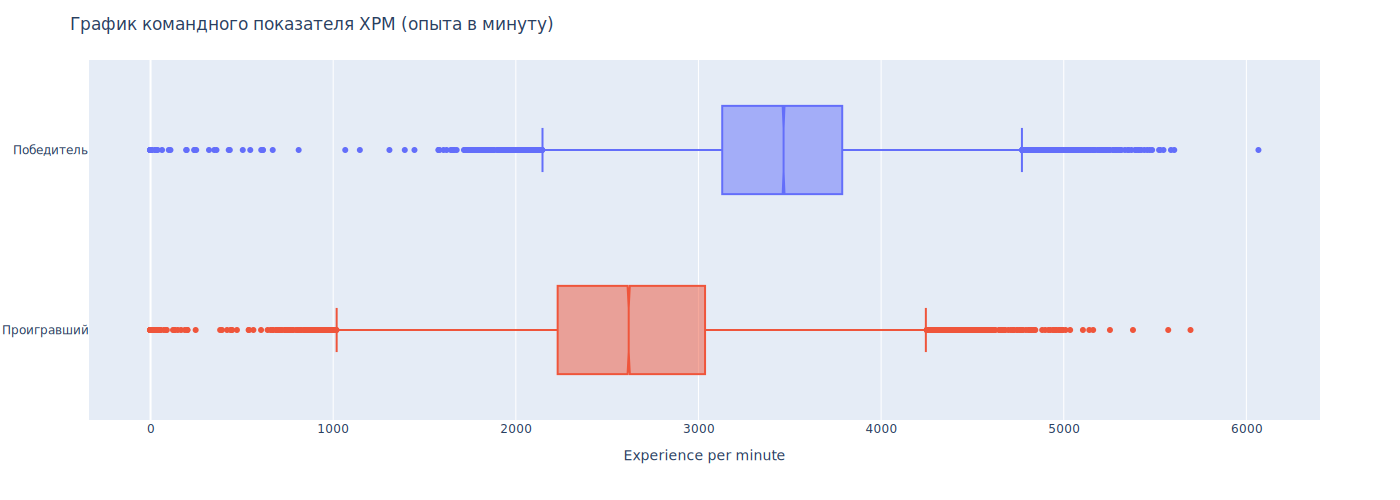

In [67]:
# @title Experience Per Minute

winners_xpm = players[['match_id','account_id', 'win', 'xp_per_min']].query('win == 1').groupby('match_id')['xp_per_min'].sum().to_frame()
winners_xpm['result'] = 'Победитель'
losers_xpm = players[['match_id','account_id', 'win', 'xp_per_min']].query('win == 0').groupby('match_id')['xp_per_min'].sum().to_frame()
losers_xpm['result'] = 'Проигравший'

xpm = pd.concat([winners_xpm, losers_xpm], ignore_index=True)

fig = px.box(
    xpm,
    x='xp_per_min',
    y='result',
    notched=True,
    color='result',
    color_discrete_map=color_discrete_map
)
fig.update_layout(
    height=500,
    width=1400,
    title='График командного показателя XPM (опыта в минуту)',
    xaxis_title='Experience per minute',
    yaxis_title=None,
    #legend=dict(title='Результат')
    showlegend=False,
)

fig.show()

In [68]:
xpm['is_win'] = xpm.result.map(lambda x: True if x == 'Победитель' else False)
xpm.xp_per_min.corr(xpm.is_win)

0.5821928855024605

Ссумарный командный показатель количества полученного опыта в минуту тоже влияет на результат матча.

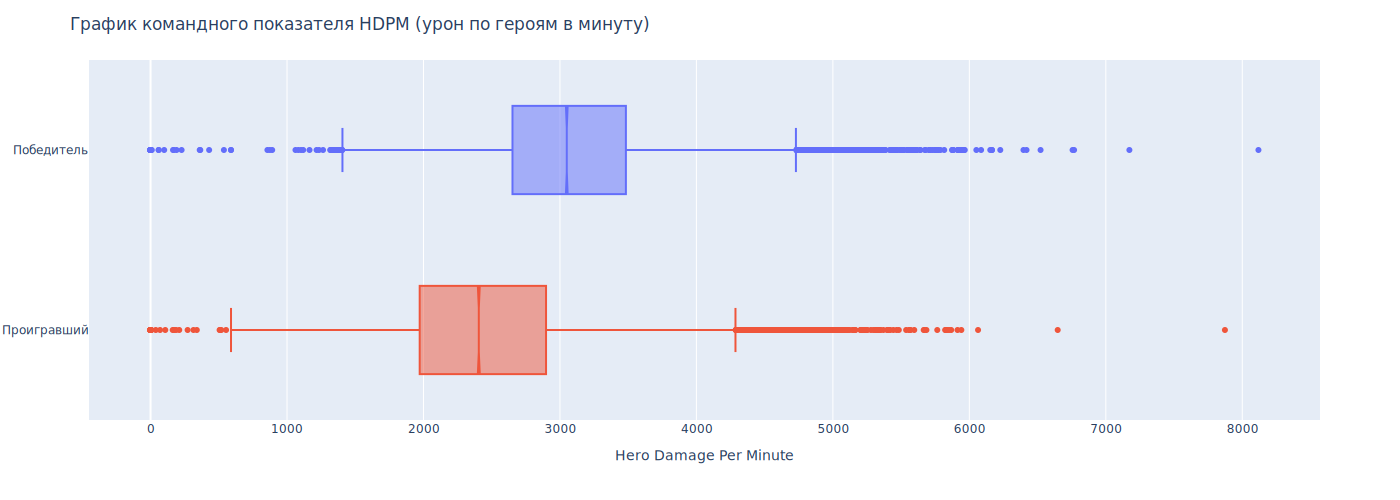

In [69]:
# @title Hero Damage Per Minute

winners_hdpm = (
    players[['match_id','account_id', 'win', 'hero_damage']]
    .query('win == 1')
    .groupby('match_id')['hero_damage']
    .sum()
    .to_frame()
    .join(matches[['match_id', 'duration']].set_index('match_id'))
)
winners_hdpm['hdpm'] = winners_hdpm.hero_damage	/ (winners_hdpm.duration / 60)
winners_hdpm['result'] = 'Победитель'


losers_hdpm = (
    players[['match_id','account_id', 'win', 'hero_damage']]
    .query('win == 0')
    .groupby('match_id')['hero_damage']
    .sum()
    .to_frame()
    .join(matches[['match_id', 'duration']].set_index('match_id'))
)
losers_hdpm['hdpm'] = losers_hdpm.hero_damage	/ (losers_hdpm.duration / 60)
losers_hdpm['result'] = 'Проигравший'

hdpm = pd.concat([winners_hdpm, losers_hdpm], ignore_index=True)

fig = px.box(
    hdpm,
    x='hdpm',
    y='result',
    notched=True,
    color='result',
    color_discrete_map=color_discrete_map
)
fig.update_layout(
    height=500,
    width=1400,
    title='График командного показателя HDPM (урон по героям в минуту)',
    xaxis_title='Hero Damage Per Minute',
    yaxis_title=None,
    #legend=dict(title='Результат')
    showlegend=False,
)

fig.show()

In [70]:
hdpm['is_win'] = hdpm.result.map(lambda x: True if x == 'Победитель' else False)
hdpm.hdpm.corr(hdpm.is_win)

0.4190066128721674

Показатель суммарного урона по вражеским героям в минуту также влияет на победу, хоть и менее значительно, чем предыдущие показатели.

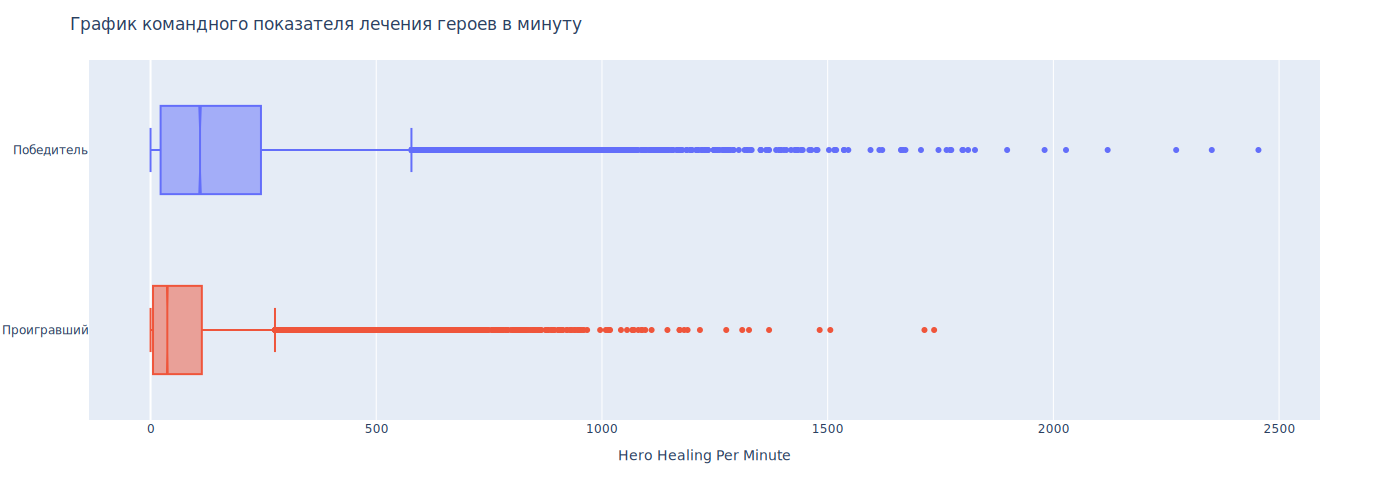

In [71]:
# @title Hero Healing Per Minute

winners_hero_healing = (
    players[['match_id','account_id', 'win', 'hero_healing']]
    .query('win == 1')
    .groupby('match_id')['hero_healing']
    .sum()
    .to_frame()
    .join(matches[['match_id', 'duration']].set_index('match_id'))
)
winners_hero_healing['hero_healing_per_min'] = winners_hero_healing.hero_healing	/ (winners_hero_healing.duration / 60)
winners_hero_healing['result'] = 'Победитель'


losers_hero_healing = (
    players[['match_id','account_id', 'win', 'hero_healing']]
    .query('win == 0')
    .groupby('match_id')['hero_healing']
    .sum()
    .to_frame()
    .join(matches[['match_id', 'duration']].set_index('match_id'))
)
losers_hero_healing['hero_healing_per_min'] = losers_hero_healing.hero_healing	/ (losers_hero_healing.duration / 60)
losers_hero_healing['result'] = 'Проигравший'

hero_healing = pd.concat([winners_hero_healing, losers_hero_healing], ignore_index=True)

fig = px.box(
    hero_healing,
    x='hero_healing_per_min',
    y='result',
    notched=True,
    color='result',
    color_discrete_map=color_discrete_map
)
fig.update_layout(
    height=500,
    width=1400,
    title='График командного показателя лечения героев в минуту',
    xaxis_title='Hero Healing Per Minute',
    yaxis_title=None,
    #legend=dict(title='Результат')
    showlegend=False,
)

fig.show()

In [72]:
hero_healing['is_win'] = hero_healing.result.map(lambda x: True if x == 'Победитель' else False)
hero_healing.hero_healing_per_min.corr(hero_healing.is_win)

0.25505917913987913

Количество восстановленных HP союзным героям в минуту на победу влияет, но не сильно, значение корреляции всего 0.25

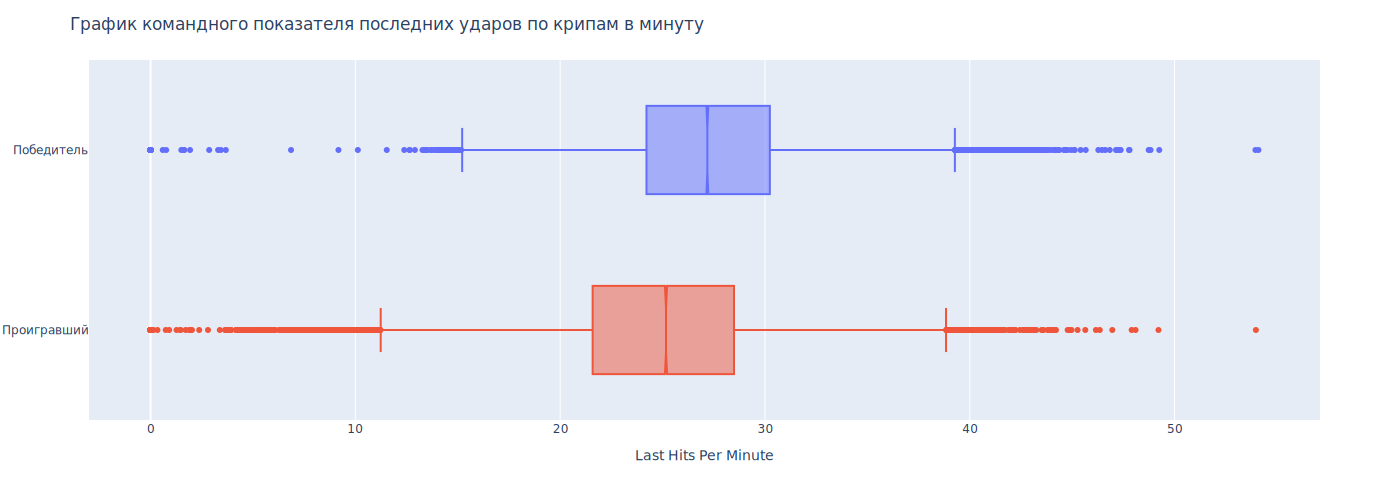

In [73]:
# @title Last Hits Per Minute

winners_last_hits = (
    players[['match_id','account_id', 'win', 'last_hits']]
    .query('win == 1')
    .groupby('match_id')['last_hits']
    .sum()
    .to_frame()
    .join(matches[['match_id', 'duration']].set_index('match_id'))
)
winners_last_hits['last_hits_per_min'] = winners_last_hits.last_hits	/ (winners_last_hits.duration / 60)
winners_last_hits['result'] = 'Победитель'


losers_last_hits = (
    players[['match_id','account_id', 'win', 'last_hits']]
    .query('win == 0')
    .groupby('match_id')['last_hits']
    .sum()
    .to_frame()
    .join(matches[['match_id', 'duration']].set_index('match_id'))
)
losers_last_hits['last_hits_per_min'] = losers_last_hits.last_hits	/ (losers_last_hits.duration / 60)
losers_last_hits['result'] = 'Проигравший'

last_hits = pd.concat([winners_last_hits, losers_last_hits], ignore_index=True)

fig = px.box(
    last_hits,
    x='last_hits_per_min',
    y='result',
    notched=True,
    color='result',
    color_discrete_map=color_discrete_map
)
fig.update_layout(
    height=500,
    width=1400,
    title='График командного показателя последних ударов по крипам в минуту',
    xaxis_title='Last Hits Per Minute',
    yaxis_title=None,
    #legend=dict(title='Результат')
    showlegend=False,
)

fig.show()

In [74]:
last_hits['is_win'] = last_hits.result.map(lambda x: True if x == 'Победитель' else False)
last_hits.last_hits_per_min.corr(last_hits.is_win)

0.22584567562558558

Как и прошлый показатель, количество последних ударов по крипам в минуту на победу влияет незначительно, значение корреляции всего 0.22

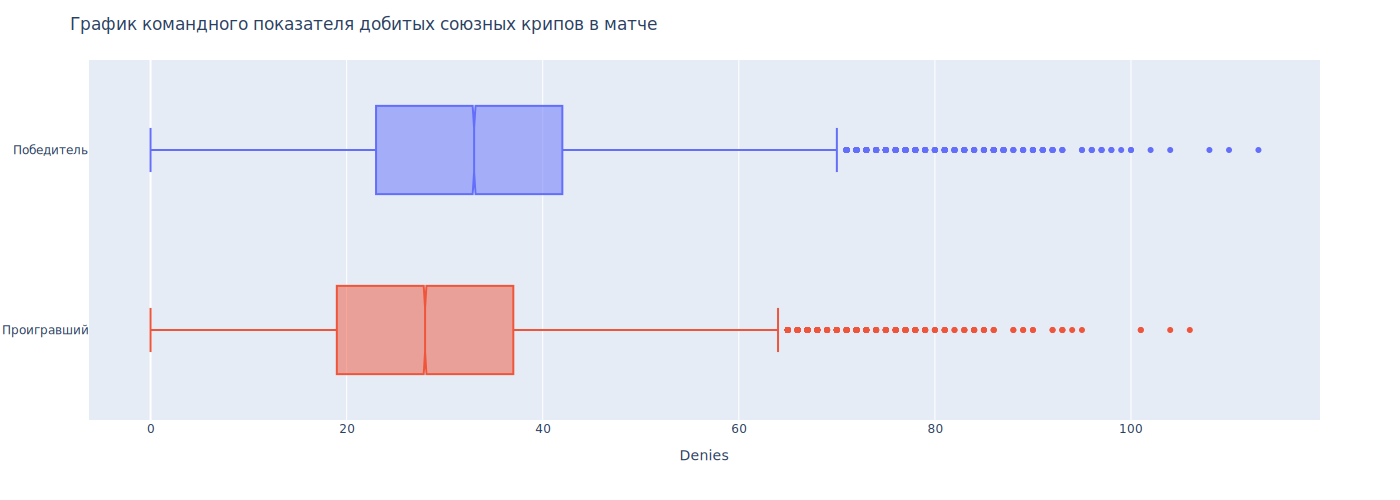

In [75]:
# @title Denies

winners_denies = players[['match_id','account_id', 'win', 'denies']].query('win == 1').groupby('match_id')['denies'].sum().to_frame()
winners_denies['result'] = 'Победитель'
losers_denies = players[['match_id','account_id', 'win', 'denies']].query('win == 0').groupby('match_id')['denies'].sum().to_frame()
losers_denies['result'] = 'Проигравший'

denies = pd.concat([winners_denies, losers_denies], ignore_index=True)

fig = px.box(
    denies,
    x='denies',
    y='result',
    notched=True,
    color='result',
    color_discrete_map=color_discrete_map
)
fig.update_layout(
    height=500,
    width=1400,
    title='График командного показателя добитых союзных крипов в матче',
    xaxis_title='Denies',
    yaxis_title=None,
    #legend=dict(title='Результат')
    showlegend=False,
)

fig.show()

In [76]:
denies['is_win'] = denies.result.map(lambda x: True if x == 'Победитель' else False)
denies.denies.corr(denies.is_win)

0.16063205147367943

Показатель добитых союзных крипов считал как сумму для команды, без деления на время матча т.к. игроки добивают союзных крипов в основном на стадии лейнинга, это первые 10-15 минут матча.

Как видно из графика у победителей этот показатель выше, но на победу влияет незначительно, показатель корреляции 0.16

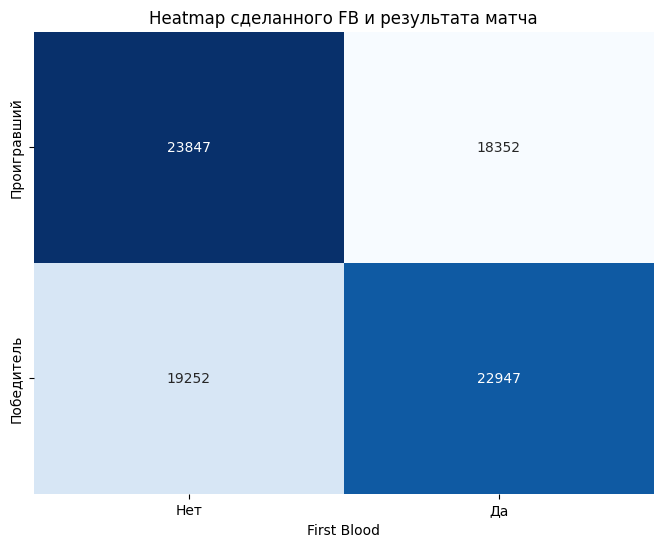

In [77]:
# @title First Blood

winners_fb = players[['match_id','account_id', 'win', 'firstblood_claimed']].query('win == 1').groupby('match_id')['firstblood_claimed'].sum().to_frame()
winners_fb['is_win'] = True

losers_fb = players[['match_id','account_id', 'win', 'firstblood_claimed']].query('win == 0').groupby('match_id')['firstblood_claimed'].sum().to_frame()
losers_fb['is_win'] = False

fb = pd.concat([winners_fb, losers_fb], ignore_index=True)
#fb_pv = fb.pivot_table(index='is_win', columns='firstblood_claimed', aggfunc='size', fill_value=0)
fb_pv = pd.crosstab(fb['is_win'], fb['firstblood_claimed'])

plt.figure(figsize=(8, 6))
heatmap(fb_pv, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('First Blood')
plt.ylabel('')
plt.xticks([0.5, 1.5], ['Нет', 'Да'])
plt.yticks([0.5, 1.5], ['Проигравший', 'Победитель'])
plt.title('Heatmap сделанного FB и результата матча')
plt.show()

In [78]:
fb.firstblood_claimed.corr(fb.is_win)

0.10891360943638369

Из графика видно, что команды отдавшие ФБ чаще проигрывают, но корреляция этих показателей слабая, всего 0.1, что говорит о опчти полном отсутствии зависимости этих значений.

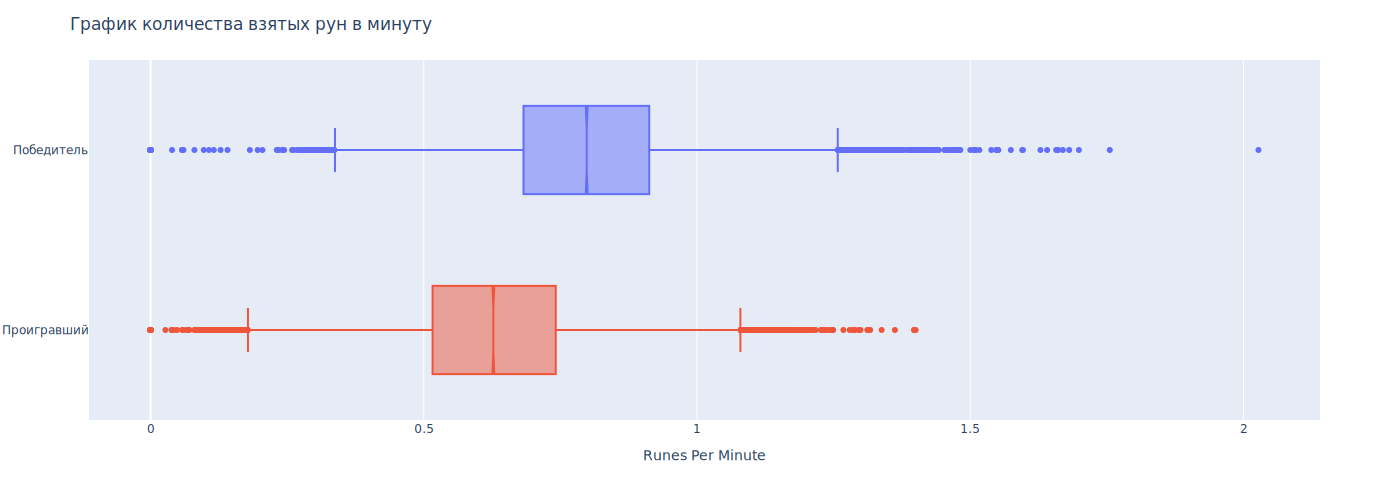

In [79]:
# @title Runes Per Minute

winners_runes = (
    players[['match_id','account_id', 'win', 'rune_pickups']]
    .query('win == 1')
    .groupby('match_id')['rune_pickups']
    .sum()
    .to_frame()
    .join(matches[['match_id', 'duration']].set_index('match_id'))
)
winners_runes['rune_pickups_per_min'] = winners_runes.rune_pickups	/ (winners_runes.duration / 60)
winners_runes['result'] = 'Победитель'


losers_runes = (
    players[['match_id','account_id', 'win', 'rune_pickups']]
    .query('win == 0')
    .groupby('match_id')['rune_pickups']
    .sum()
    .to_frame()
    .join(matches[['match_id', 'duration']].set_index('match_id'))
)
losers_runes['rune_pickups_per_min'] = losers_runes.rune_pickups	/ (losers_runes.duration / 60)
losers_runes['result'] = 'Проигравший'

runes = pd.concat([winners_runes, losers_runes], ignore_index=True)

fig = px.box(
    runes,
    x='rune_pickups_per_min',
    y='result',
    notched=True,
    color='result',
    color_discrete_map=color_discrete_map
)
fig.update_layout(
    height=500,
    width=1400,
    title='График количества взятых рун в минуту',
    xaxis_title='Runes Per Minute',
    yaxis_title=None,
    #legend=dict(title='Результат')
    showlegend=False,
)

fig.show()

In [80]:
runes['is_win'] = runes.result.map(lambda x: True if x == 'Победитель' else False)
runes.rune_pickups_per_min.corr(runes.is_win)

0.4418646678411605

Количество взятых рун в матче за минуту у победителей тоже больше, корреляция этого показателя - 0.44

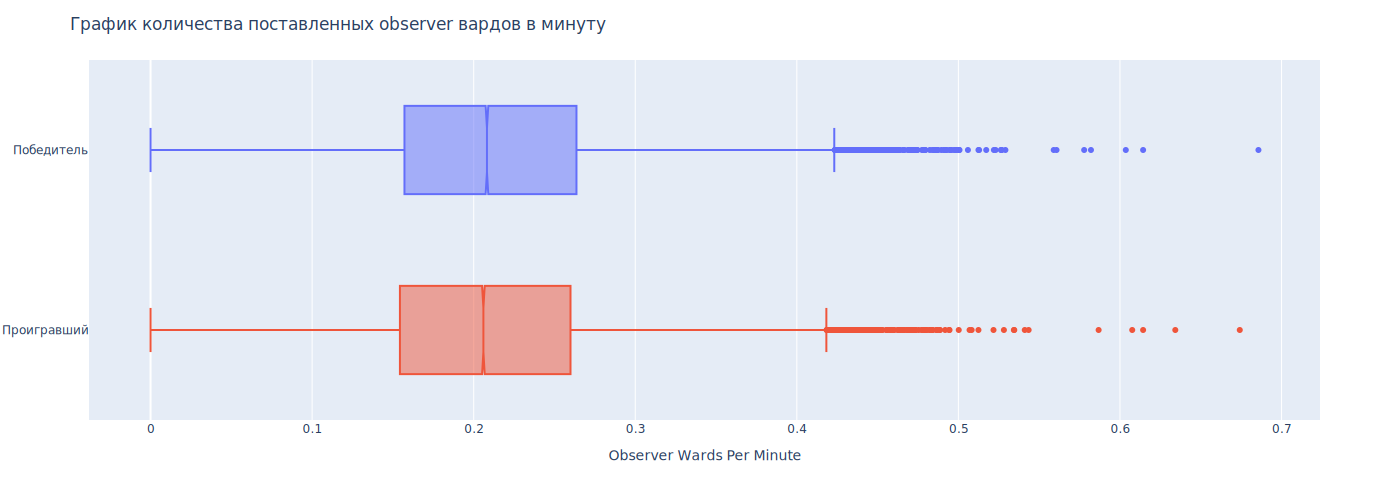

In [81]:
# @title Observer Wards Per Minute

winners_obs = (
    players[['match_id','account_id', 'win', 'observer_uses']]
    .query('win == 1')
    .groupby('match_id')['observer_uses']
    .sum()
    .to_frame()
    .join(matches[['match_id', 'duration']].set_index('match_id'))
)
winners_obs['observer_uses_per_min'] = winners_obs.observer_uses	/ (winners_obs.duration / 60)
winners_obs['result'] = 'Победитель'


losers_obs = (
    players[['match_id','account_id', 'win', 'observer_uses']]
    .query('win == 0')
    .groupby('match_id')['observer_uses']
    .sum()
    .to_frame()
    .join(matches[['match_id', 'duration']].set_index('match_id'))
)
losers_obs['observer_uses_per_min'] = losers_obs.observer_uses	/ (losers_obs.duration / 60)
losers_obs['result'] = 'Проигравший'

obs = pd.concat([winners_obs, losers_obs], ignore_index=True)

fig = px.box(
    obs,
    x='observer_uses_per_min',
    y='result',
    notched=True,
    color='result',
    color_discrete_map=color_discrete_map
)
fig.update_layout(
    height=500,
    width=1400,
    title='График количества поставленных observer вардов в минуту',
    xaxis_title='Observer Wards Per Minute',
    yaxis_title=None,
    #legend=dict(title='Результат')
    showlegend=False,
)

fig.show()

In [82]:
obs['is_win'] = obs.result.map(lambda x: True if x == 'Победитель' else False)
obs.observer_uses_per_min.corr(obs.is_win)

0.022515029088344258

Интересно, и проигравшие и победители ставят одинаковое количество вардов за минуту, корреляция этого показателя к результату матча нулевая

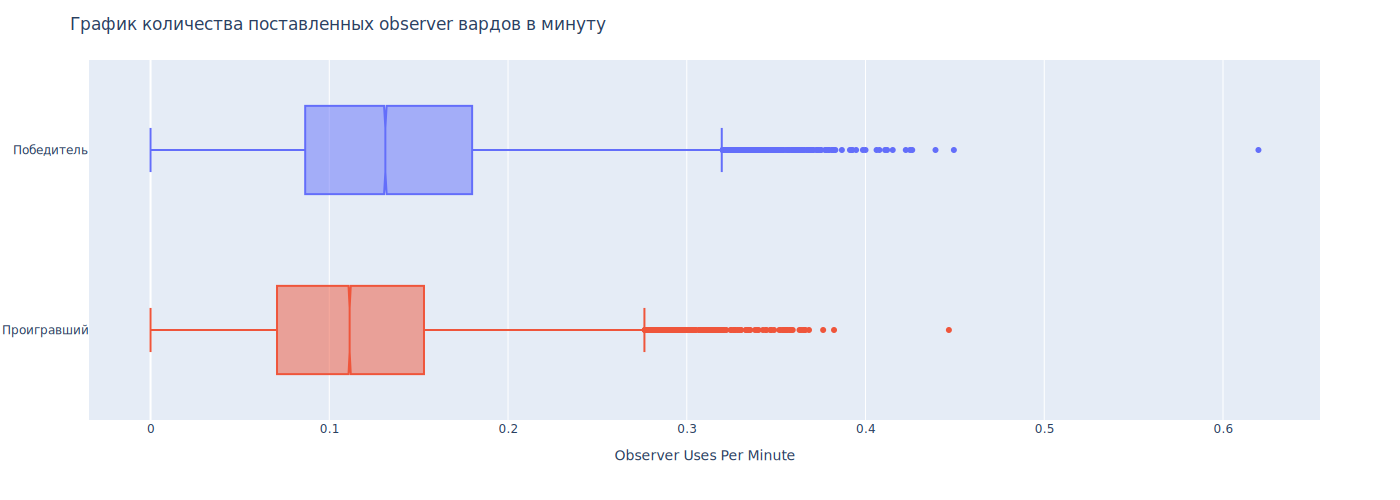

In [83]:
# @title Observers Destroyed Per Minute

winners_obs_kills = (
    players[['match_id','account_id', 'win', 'observer_kills']]
    .query('win == 1')
    .groupby('match_id')['observer_kills']
    .sum()
    .to_frame()
    .join(matches[['match_id', 'duration']].set_index('match_id'))
)
winners_obs_kills['observer_kills_per_min'] = winners_obs_kills.observer_kills	/ (winners_obs_kills.duration / 60)
winners_obs_kills['result'] = 'Победитель'


losers_obs_kills = (
    players[['match_id','account_id', 'win', 'observer_kills']]
    .query('win == 0')
    .groupby('match_id')['observer_kills']
    .sum()
    .to_frame()
    .join(matches[['match_id', 'duration']].set_index('match_id'))
)
losers_obs_kills['observer_kills_per_min'] = losers_obs_kills.observer_kills	/ (losers_obs_kills.duration / 60)
losers_obs_kills['result'] = 'Проигравший'

obs_kills = pd.concat([winners_obs_kills, losers_obs_kills], ignore_index=True)

fig = px.box(
    obs_kills,
    x='observer_kills_per_min',
    y='result',
    notched=True,
    color='result',
    color_discrete_map=color_discrete_map
)
fig.update_layout(
    height=500,
    width=1400,
    title='График количества поставленных observer вардов в минуту',
    xaxis_title='Observer Uses Per Minute',
    yaxis_title=None,
    #legend=dict(title='Результат')
    showlegend=False,
)

fig.show()

In [84]:
obs_kills['is_win'] = obs_kills.result.map(lambda x: True if x == 'Победитель' else False)
obs_kills.observer_kills_per_min.corr(obs_kills.is_win)

0.16418274305510147

Уничтожение чужих observer вардов почти не влияет на результат матча, показатель корреляции - 0.16

# Проверка гипотез

In [85]:
alpha = .05

## First Blood

Формулируем гипотезы:

>$H_0$ - Между сделанным First Blood и результатом матча связи <u>нет</u>
>
>$H_1$ - Между сделанным First Blood и результатом матча связь <u>есть</u>
>

Проверять наличие связи между двумя категориальными переменными будем тестом на независимость кси-квадрат

In [86]:
fb_pv

firstblood_claimed   0.00   1.00
is_win                          
False               23847  18352
True                19252  22947

In [87]:
# Для удобства давайте развернем сводную, чтобы получить массив данных
pivot_array = fb_pv.to_numpy()
pivot_array

array([[23847, 18352],
       [19252, 22947]])

In [88]:
# Выполним тест хи-квадрат
chi2, p_val, dof, expected = chi2_contingency(pivot_array)

In [89]:
# Выведем результаты теста
print(f"Chi-squared: {chi2}")
print(f"P-value: {p_val}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)

Chi-squared: 1000.7080821612144
P-value: 1.2599531893740449e-219
Degrees of freedom: 1
Expected frequencies:
[[21549.5 20649.5]
 [21549.5 20649.5]]


In [90]:
if p_val > alpha:
  print('Нулевая гипотеза верна')
else:
  print('Отклоняем нулевую гипотезу')

Отклоняем нулевую гипотезу


P-value очень мало, можно отклонить нулевую гипотезу о том, что между сделанным First Blood и результатом матча связи нет, и сделать вывод о наличии статистически значимой связи между показателями.

## Средний винрейт игроков команды

Формулируем гипотезы:

>$H_0$ - Между средним значением среднего винрейта игроков команды и результатом матча связи <u>нет</u>
>
>$H_1$ - Между средним значением среднего винрейта игроков команды и результатом матча связь <u>есть</u>
>

In [91]:
group_winner = win_players_mean_winrate['mean_player_winrate']
group_loser = lose_players_mean_winrate['mean_player_winrate']

In [92]:
def equal_var(
    group_a: pd.core.series.Series,
    group_b: pd.core.series.Series
    ) -> None:
  '''
  Проверка на соотношение дисперсий групп
  Если дисперсии групп равны, то проводим t-тест Стьюдента
  Если дисперсии различаются более чем в 4 раза, значит они не равны, проводим t-тест Уэлча
  Args:
    group_a (pd.core.series.Series): поле датафрейма с наблюдениями группы A
    group_b (pd.core.series.Series): поле датафрейма с наблюдениями группы B
  Returns:
    None: Используемый тест выводится функцией print
  '''
  var_a = np.var(group_a)
  var_b = np.var(group_b)
  if var_a / var_b > 4 or var_a / var_b < 0.25:
    print('Welch’s t-test')
  else:
    print('Student’s t-test')

In [93]:
equal_var(group_winner, group_loser)

Student’s t-test


In [94]:
# T-тест между двумя группами
t_stat, p_val = ttest_ind(group_winner, group_loser, equal_var=True)

print(f"Значение t-статистики: {t_stat}")
print(f"P-value для t-теста: {p_val}")

Значение t-статистики: 74.87583504105943
P-value для t-теста: 0.0


In [95]:
if p_val > alpha:
  print('Нулевая гипотеза верна')
else:
  print('Отклоняем нулевую гипотезу')

Отклоняем нулевую гипотезу


P-value - 0, отклоняем нулевую гипотезу о том, что между значением среднего винрейта игроков команды и результатом матча связи нет, и делаем вывод о наличии статистически значимой связи между показателями.

**Текст, выделенный полужирным шрифтом**### KDA

Формулируем гипотезы:

>$H_0$ - Между средним значением KDA команды и результатом матча связи <u>нет</u>
>
>$H_1$ - Между средним значением KDA команды и результатом матча связь <u>есть</u>
>

In [96]:
group_winner = winners_kda['kda']
group_loser = losers_kda['kda']

In [97]:
equal_var(group_winner, group_loser)

Welch’s t-test


In [98]:
# T-тест между двумя группами
t_stat, p_val = ttest_ind(group_winner, group_loser, equal_var=False)

print(f"Значение t-статистики: {t_stat}")
print(f"P-value для t-теста: {p_val}")

Значение t-статистики: 318.0281337207667
P-value для t-теста: 0.0


In [99]:
if p_val > alpha:
  print('Нулевая гипотеза верна')
else:
  print('Отклоняем нулевую гипотезу')

Отклоняем нулевую гипотезу


P-value - 0, отклоняем нулевую гипотезу о том, что между значением KDA команды и результатом матча связи нет, и делаем вывод о наличии статистически значимой связи между показателями.

## Gold Per Minute

Формулируем гипотезы:

>$H_0$ - Между значением GPM команды и результатом матча связи <u>нет</u>
>
>$H_1$ - Между значением GPM команды и результатом матча связь <u>есть</u>
>

In [100]:
group_winner = winners_gpm['gold_per_min']
group_loser = losers_gpm['gold_per_min']

In [101]:
equal_var(group_winner, group_loser)

Student’s t-test


In [102]:
# T-тест между двумя группами
t_stat, p_val = ttest_ind(group_winner, group_loser, equal_var=True)

print(f"Значение t-статистики: {t_stat}")
print(f"P-value для t-теста: {p_val}")

Значение t-статистики: 303.1918742905301
P-value для t-теста: 0.0


In [103]:
if p_val > alpha:
  print('Нулевая гипотеза верна')
else:
  print('Отклоняем нулевую гипотезу')

Отклоняем нулевую гипотезу


P-value - 0, отклоняем нулевую гипотезу о том, что между количеством GPM и результатом матча связи нет, и делаем вывод о наличии статистически значимой связи между показателями.

## Experience Per Minute

Формулируем гипотезы:

>$H_0$ - Между количеством XPM и результатом матча связи <u>нет</u>
>
>$H_1$ - Между количеством XPM и результатом матча связь <u>есть</u>
>

In [104]:
group_winner = winners_xpm['xp_per_min']
group_loser = losers_xpm['xp_per_min']

In [105]:
equal_var(group_winner, group_loser)

Student’s t-test


In [106]:
# T-тест между двумя группами
t_stat, p_val = ttest_ind(group_winner, group_loser, equal_var=True)

print(f"Значение t-статистики: {t_stat}")
print(f"P-value для t-теста: {p_val}")

Значение t-статистики: 208.0224450010908
P-value для t-теста: 0.0


In [107]:
if p_val > alpha:
  print('Нулевая гипотеза верна')
else:
  print('Отклоняем нулевую гипотезу')

Отклоняем нулевую гипотезу


P-value - 0, отклоняем нулевую гипотезу о том, что между количеством XPM и результатом матча связи нет, и делаем вывод о наличии статистически значимой связи между показателями.

## Hero Damage Per Minute

Формулируем гипотезы:

>$H_0$ - Между количеством Hero Damage Per Minute и результатом матча связи <u>нет</u>
>
>$H_1$ - Между количеством Hero Damage Per Minute и результатом матча связь <u>есть</u>
>

In [108]:
group_winner = winners_hdpm['hdpm']
group_loser = losers_hdpm['hdpm']

In [109]:
equal_var(group_winner, group_loser)

Student’s t-test


In [110]:
# T-тест между двумя группами
t_stat, p_val = ttest_ind(group_winner, group_loser, equal_var=True)

print(f"Значение t-статистики: {t_stat}")
print(f"P-value для t-теста: {p_val}")

Значение t-статистики: 134.0614784595878
P-value для t-теста: 0.0


In [111]:
if p_val > alpha:
  print('Нулевая гипотеза верна')
else:
  print('Отклоняем нулевую гипотезу')

Отклоняем нулевую гипотезу


P-value - 0, отклоняем нулевую гипотезу о том, что между показателем Hero Damage Per Minute и результатом матча связи нет, и делаем вывод о наличии статистически значимой связи между показателями.

## Hero Healing Per Minute

Формулируем гипотезы:

>$H_0$ - Между количеством Hero Healing Per Minute и результатом матча связи <u>нет</u>
>
>$H_1$ - Между количеством Hero Healing Per Minute и результатом матча связь <u>есть</u>
>

In [112]:
group_winner = winners_hero_healing['hero_healing_per_min']
group_loser = losers_hero_healing['hero_healing_per_min']

In [113]:
equal_var(group_winner, group_loser)

Student’s t-test


In [114]:
# T-тест между двумя группами
t_stat, p_val = ttest_ind(group_winner, group_loser, equal_var=True)

print(f"Значение t-статистики: {t_stat}")
print(f"P-value для t-теста: {p_val}")

Значение t-статистики: 76.6317777381448
P-value для t-теста: 0.0


In [115]:
if p_val > alpha:
  print('Нулевая гипотеза верна')
else:
  print('Отклоняем нулевую гипотезу')

Отклоняем нулевую гипотезу


P-value - 0, отклоняем нулевую гипотезу о том, что между показателем Hero Healing Per Minute и результатом матча связи нет, и делаем вывод о наличии статистически значимой связи между показателями.

## Last Hits Per Minute

Формулируем гипотезы:

>$H_0$ - Между количеством ластхитов в минуту и результатом матча связи <u>нет</u>
>
>$H_1$ - Между количеством ластхитов в минуту и результатом матча связь <u>есть</u>
>

In [116]:
group_winner = winners_last_hits['last_hits_per_min']
group_loser = losers_last_hits['last_hits_per_min']

In [117]:
print(np.var(group_winner), np.var(group_loser))

22.05482810540309 30.398700665415483


In [118]:
equal_var(group_winner, group_loser)

Student’s t-test


In [119]:
# T-тест между двумя группами
t_stat, p_val = ttest_ind(group_winner, group_loser, equal_var=True)

print(f"Значение t-статистики: {t_stat}")
print(f"P-value для t-теста: {p_val}")

Значение t-статистики: 67.3505333649938
P-value для t-теста: 0.0


In [120]:
if p_val > alpha:
  print('Нулевая гипотеза верна')
else:
  print('Отклоняем нулевую гипотезу')

Отклоняем нулевую гипотезу


P-value - 0, отклоняем нулевую гипотезу о том, что между количеством ластхитов в минуту и результатом матча связи нет, и делаем вывод о наличии статистически значимой связи между показателями.

## Denies

Формулируем гипотезы:

>$H_0$ - Между количеством добитых союзных крипов и результатом матча связи <u>нет</u>
>
>$H_1$ - Между количеством добитых союзных крипов и результатом матча связь <u>есть</u>
>

In [121]:
group_winner = winners_denies['denies']
group_loser = losers_denies['denies']

In [122]:
equal_var(group_winner, group_loser)

Student’s t-test


In [123]:
# T-тест между двумя группами
t_stat, p_val = ttest_ind(group_winner, group_loser, equal_var=True)

print(f"Значение t-статистики: {t_stat}")
print(f"P-value для t-теста: {p_val}")

Значение t-статистики: 47.27915075648743
P-value для t-теста: 0.0


In [124]:
if p_val > alpha:
  print('Нулевая гипотеза верна')
else:
  print('Отклоняем нулевую гипотезу')

Отклоняем нулевую гипотезу


P-value - 0, отклоняем нулевую гипотезу о том, что между количеством добитых союзных крипов и результатом матча связи нет, и делаем вывод о наличии статистически значимой связи между показателями.

## Runes

Формулируем гипотезы:

>$H_0$ - Между количеством взятых рун в минуту и результатом матча связи <u>нет</u>
>
>$H_1$ - Между количеством взятых рун в минуту и результатом матча связь <u>есть</u>
>

In [125]:
group_winner = winners_runes['rune_pickups_per_min']
group_loser = losers_runes['rune_pickups_per_min']

In [126]:
equal_var(group_winner, group_loser)

Student’s t-test


In [127]:
# T-тест между двумя группами
t_stat, p_val = ttest_ind(group_winner, group_loser, equal_var=True)

print(f"Значение t-статистики: {t_stat}")
print(f"P-value для t-теста: {p_val}")

Значение t-статистики: 143.09293774582005
P-value для t-теста: 0.0


In [128]:
if p_val > alpha:
  print('Нулевая гипотеза верна')
else:
  print('Отклоняем нулевую гипотезу')

Отклоняем нулевую гипотезу


P-value - 0, отклоняем нулевую гипотезу о том, что между количеством взятых рун в минуту и результатом матча связи нет, и делаем вывод о наличии статистически значимой связи между показателями.

## Observer Wards Per Minute

Формулируем гипотезы:

>$H_0$ - Между количеством поставленных observer вардов в минуту и результатом матча связи <u>нет</u>
>
>$H_1$ - Между количеством поставленных observer вардов в минуту и результатом матча связь <u>есть</u>
>

In [129]:
group_winner = winners_obs['observer_uses_per_min']
group_loser = losers_obs['observer_uses_per_min']

In [130]:
equal_var(group_winner, group_loser)

Student’s t-test


In [131]:
# T-тест между двумя группами
t_stat, p_val = ttest_ind(group_winner, group_loser, equal_var=True)

print(f"Значение t-статистики: {t_stat}")
print(f"P-value для t-теста: {p_val}")

Значение t-статистики: 6.542497264471232
P-value для t-теста: 6.084435368470986e-11


In [132]:
if p_val > alpha:
  print('Нулевая гипотеза верна')
else:
  print('Отклоняем нулевую гипотезу')

Отклоняем нулевую гипотезу


P-value очень мало, отклоняем нулевую гипотезу о том, что между количеством поставленных observer вардов в минуту и результатом матча связи нет, и делаем вывод о наличии статистически значимой связи между показателями.

## Observers Destroyed Per Minute

Формулируем гипотезы:

>$H_0$ - Между количеством уничтоженных observer вардов противника в минуту и результатом матча связи <u>нет</u>
>
>$H_1$ - Между количеством уничтоженных observer вардов противника в минуту и результатом матча связь <u>есть</u>
>

In [133]:
group_winner = winners_obs_kills['observer_kills_per_min']
group_loser = losers_obs_kills['observer_kills_per_min']

In [134]:
equal_var(group_winner, group_loser)

Student’s t-test


In [135]:
# T-тест между двумя группами
t_stat, p_val = ttest_ind(group_winner, group_loser, equal_var=True)

print(f"Значение t-статистики: {t_stat}")
print(f"P-value для t-теста: {p_val}")

Значение t-статистики: 48.35286294471494
P-value для t-теста: 0.0


In [136]:
if p_val > alpha:
  print('Нулевая гипотеза верна')
else:
  print('Отклоняем нулевую гипотезу')

Отклоняем нулевую гипотезу


P-value - 0, отклоняем нулевую гипотезу о том, что между количеством уничтоженных observer вардов противника в минуту и результатом матча связи нет, и делаем вывод о наличии статистически значимой связи между показателями.

# Вывод

В текущей мете, начиная с патча 7.33, который вышел в апреле прошлого года, было сыграно 42199 игр на профессиональной сцене. Так как дота, а тем более её профессиональная сцена, игра командная - в этом исследовании анализировались только командные показатели.

- За все почти полтора года Radiant выиграли на 1300 матчей больше, чем Dire.

- Dire выигрывали только в одном месяце - январь 2024 года, все остальное время Radiant выигрывают чаще.

- Медианное время матча - 32 минуты. Матчи больше 57 минут уже считаются выбросами.

- Magic wand - самый покупаемый предмет в игре, его покупают чаще всего как победившие, так и проигравшие команды. При этом к концу игры в инвентарях команды остается в среднем больше двух предметов за матч.

- В топ-5 выигрышных и проигрышных предметов различается только один предмет - в инвентарях у победителей есть Аганим, у проигравших - Arcane Boots.

- Топ-5 предметов по винрейту:

| Предмет               |   Винрейт |
|:----------------------|----------:|
| Aegis of the Immortal |       99% |
| Gem of True Sight     |       90% |
| Divine Rapier         |       86% |
| Cheese                |       81% |
| Overwhelming Blink    |       73% |


- Из топ-5 самых часто пикаемых и банившихся героев пересекается только Windranger.

- Герои с самым высоким винрейтом не очень популярные - на трех из пяти героев не сыграно даже 2 тысяч матчей за полтора года.

- В большинстве матчей ФБ делают до 4 минуты, очень редко проходит больше времени. Самое позднее ФБ за время исследования - на 16 минуте

- Средний винрейт игроков команды влияет на результат матча - чем он выше, тем чаще команда побеждает

**Результаты статистических тестов**

Статистические тесты подтвердили, что на результат матча влияют все исследованные показатели:
- Средний показатель KDA (Kills + Assists) / Deaths
- Gold Per Minute
- Experience Per Minute
- Hero Damage Per Minute
- Hero Healing Per Minute
- Количество ластхитов в минуту
- Количество добитых союзных крипов
- Количество взятых рун в минуту
- Количество поставленных observer вардов в минуту
- Количество уничтоженных observer вардов противника в минуту

Чем выше эти показатели - тем чаще команда побеждает в матче.